Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

# Needed for using CRF
!git clone https://www.github.com/keras-team/keras-contrib.git
!sed -i '516s/.*/            mask2 = K.cast(K.concatenate([mask, K.cast(K.zeros_like(mask[:, :1]), mask.dtype)], axis=1),/' ./keras-contrib/keras_contrib/layers/crf.py
!pip install ./keras-contrib
from keras_contrib.layers import CRF

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
# from keras.layers import CuDNNLSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
# from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 23.92 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./keras-contrib
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip

Using TensorFlow backend.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=88579c1a112b539c87a2b2b33bbc9b7d7d550104b27dd36ce0352cc21dc584de
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['I-treatment', 'B-test', 'B-treatment', 'B-problem', 'O', 'I-test', 'I-problem']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['I-treatment', 'B-test', 'B-treatment', 'B-problem', 'O', 'I-test', 'I-problem']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-treatment', 'B-test', 'B-treatment', 'B-problem', 'O', 'I-test', 'I-problem']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

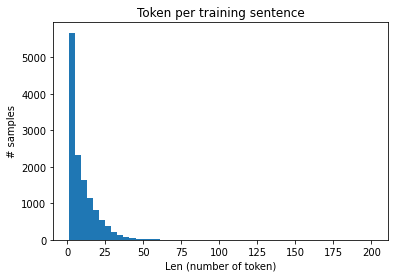

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

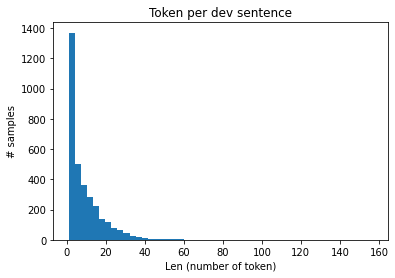

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

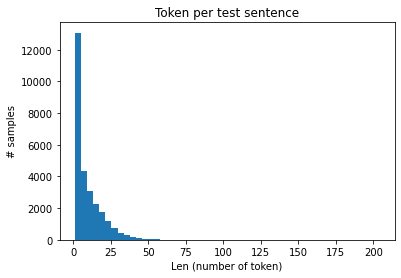

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
words.append('ENDPAD')
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i+1 for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

817
acetabulum
2
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 6526
Points in y_train before removal: 6526


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[2000, 8631, 2406, 14930, 2932, 5921, 4726]
[4, 4, 4, 4, 4, 1, 5]
[15770, 24490, 23344, 20028, 20478, 25251, 4428, 26032, 26753, 27185, 22029, 19821, 1235, 27359]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[6235, 19682, 19616]
[4, 4, 4]
817
2
B-treatment
LOS
28389
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 1.x
!git clone https://www.github.com/keras-team/keras-contrib.git
!sed -i '516s/.*/            mask2 = K.cast(K.concatenate([mask, K.cast(K.zeros_like(mask[:, :1]), mask.dtype)], axis=1),/' ./keras-contrib/keras_contrib/layers/crf.py
!pip install ./keras-contrib
from keras_contrib.layers import CRF
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 5.45 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./keras-contrib
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/

Using TensorFlow backend.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=acc768556a722f809497657d2fde54a88d0ed61ed34b5ac907b21c8de8ac8759
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[2000, 8631, 2406, 14930, 2932, 5921, 4726]
[4, 4, 4, 4, 4, 1, 5]
[15770, 24490, 23344, 20028, 20478, 25251, 4428, 26032, 26753, 27185, 22029, 19821, 1235, 27359]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[6235, 19682, 19616]
[4, 4, 4]
817
2
B-treatment
LOS
28389
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [5]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-18 05:52:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-18 05:52:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-18 05:52:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [8]:
num_tokens = n_words + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10358 words (18031 misses)


In [9]:
# Model creation function
def create_model(maxlen, n_words):
  input = Input(shape=(maxlen,))
  word_embedding_size = 100

  model = Embedding(input_dim=n_words+2, output_dim=word_embedding_size, input_length=maxlen, mask_zero=True,
                    embeddings_initializer=k.initializers.Constant(embedding_matrix),
                    trainable=True)(input)
  model = Bidirectional(LSTM(units=word_embedding_size, return_sequences=True, recurrent_dropout=0.5, dropout=0.5))(model)
  model = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  
  # out = Dense(n_tags, activation="sigmoid")(model)  
  crf = CRF(n_tags)
  out = crf(model)
  model = Model(input, out)

  # adam = k.optimizers.Adam()
  model.compile(
            loss=crf.loss_function,
            optimizer='adam',
            metrics=[crf.accuracy, "accuracy"]
        )
  # model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
  # model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

  model.summary()

  return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=100,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=n_words)
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=n_words)
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words)

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  model = None
  model = create_model(maxlen, n_words)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_1 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________

Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 122s 19ms

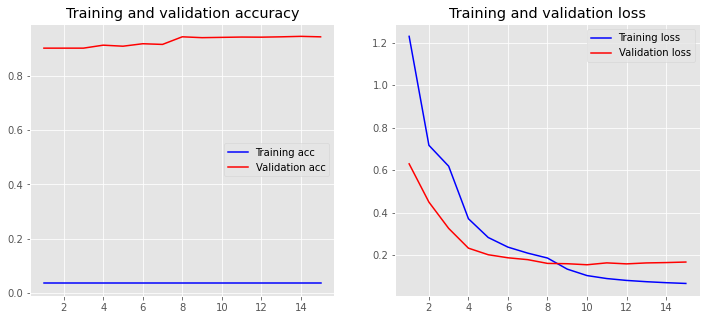

27625/27625 [==============================] - 60s 2ms/step
F1-score: 50.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.40174020153840106,0.2803388792114155,0.33023560174176714,218721.0
test,0.629476476554576,0.615537202693166,0.6224288070050242,104858.0
treatment,0.4892495110757891,0.6057471541578237,0.5413011900708181,414640.0
micro avg,0.4905794668811009,0.5107251371205563,0.5004496423766868,738219.0
macro avg,0.5068220630562553,0.5005410786874683,0.49798853293920314,738219.0
weighted avg,0.4832401770635889,0.5107251371205563,0.4902897735556223,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_2 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 123s 19ms/

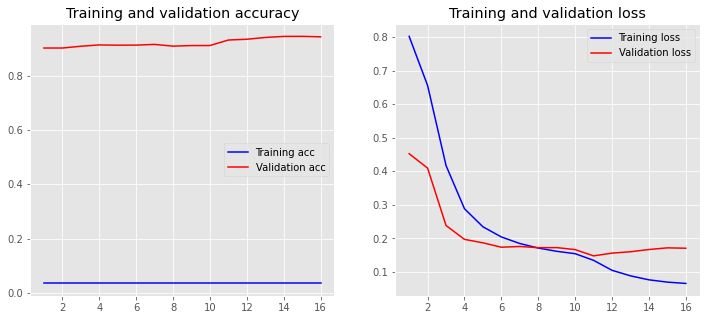

27625/27625 [==============================] - 61s 2ms/step
F1-score: 37.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.5070352795543636,0.3370869738159573,0.4049531624607628,218721.0
test,0.16113066095471237,0.20087165500009538,0.17881975396683902,104858.0
treatment,0.38881443255926584,0.4491920702295968,0.4168281733261122,414640.0
micro avg,0.37216582490021954,0.38070545461441657,0.3763872083204709,738219.0
macro avg,0.3523267910227806,0.3290502330152165,0.33353369658457127,738219.0
weighted avg,0.3915005148095256,0.38070545461441657,0.3795026627545139,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_3 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 123s 19ms/

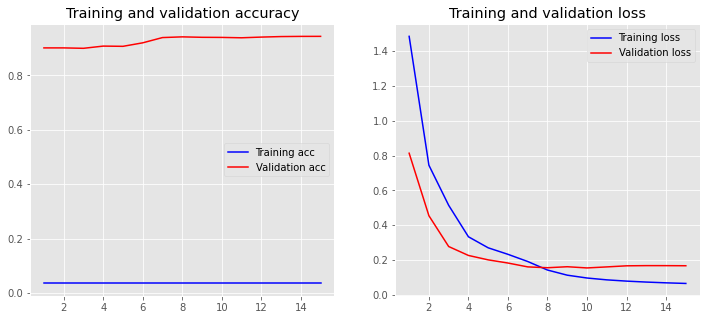

27625/27625 [==============================] - 61s 2ms/step
F1-score: 51.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.3714813021904877,0.2806817818133604,0.3197606131553384,218721.0
test,0.5702627091989604,0.6570600240325011,0.610592176394477,104858.0
treatment,0.5196896421297055,0.6196531931313911,0.565286121467003,414640.0
micro avg,0.4961363272366187,0.5245354020961259,0.5099407780632571,738219.0
macro avg,0.48714455117305117,0.5191316663257509,0.4985463036722728,738219.0
weighted avg,0.4829616716316586,0.5245354020961259,0.4989766897186322,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_4 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 129s 20ms/

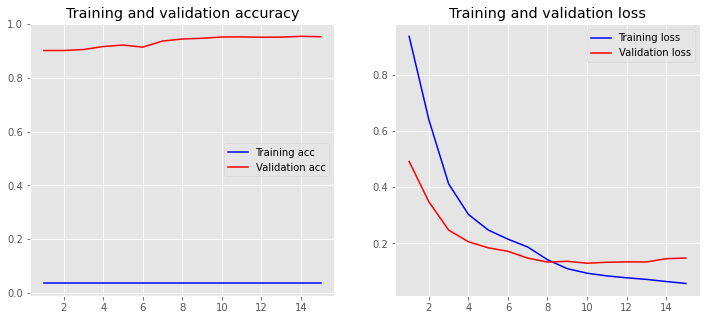

27625/27625 [==============================] - 62s 2ms/step
F1-score: 56.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.6065928885696328,0.741286844884579,0.667209866483954,218721.0
test,0.3069240777859831,0.2497091304430754,0.2753761128259601,104858.0
treatment,0.5375746100748011,0.6107949064248505,0.571850487041578,414640.0
micro avg,0.536082261461792,0.598168023310156,0.5654259398924667,738219.0
macro avg,0.48369719214347234,0.5339302939175016,0.5048121554504973,738219.0
weighted avg,0.525261452835455,0.598168023310156,0.5579919828572028,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_5 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 124s 19ms/

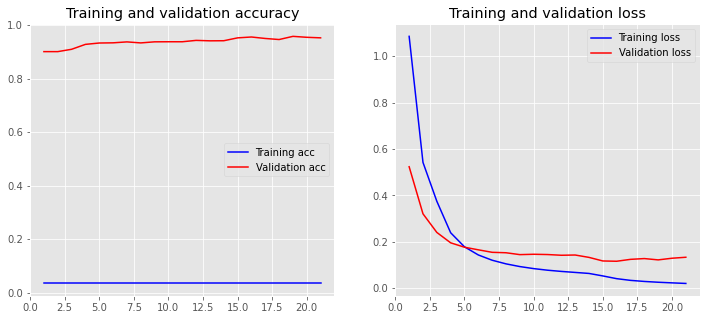

27625/27625 [==============================] - 62s 2ms/step
F1-score: 58.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.5198185840357123,0.5994760448242281,0.5568128011143221,218721.0
test,0.44498809266074907,0.7840698849873162,0.5677547666236215,104858.0
treatment,0.6189514398388228,0.5912550646343816,0.604786327316504,414640.0
micro avg,0.5503550662358178,0.621078568825782,0.5835819062268703,738219.0
macro avg,0.527919372178428,0.6582669981486421,0.5764512983514826,738219.0
weighted avg,0.5648700818508672,0.621078568825782,0.5853126033733357,738219.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_6 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 129s 20ms/

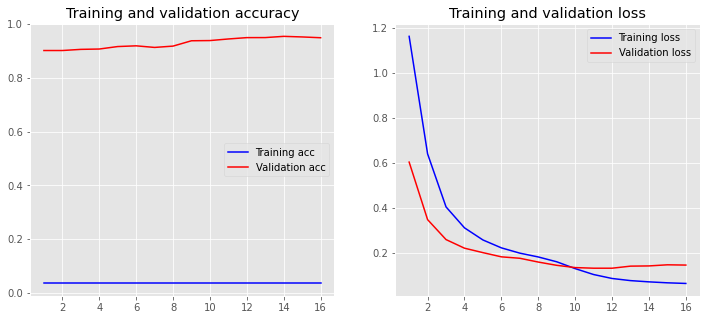

27625/27625 [==============================] - 61s 2ms/step
F1-score: 53.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.5793836666610503,0.6288742278976412,0.603115374075089,218721.0
test,0.569931506849315,0.23806481145930689,0.33584469049765237,104858.0
treatment,0.47973303804810435,0.614373914721204,0.5387690186241872,414640.0
micro avg,0.5137241817447575,0.5652184514351433,0.5382424932357693,738219.0
macro avg,0.5430160705194899,0.49377098469271735,0.49257636106564284,738219.0
weighted avg,0.522069683653825,0.5652184514351433,0.5290099363083495,738219.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_7 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 125s 19ms/

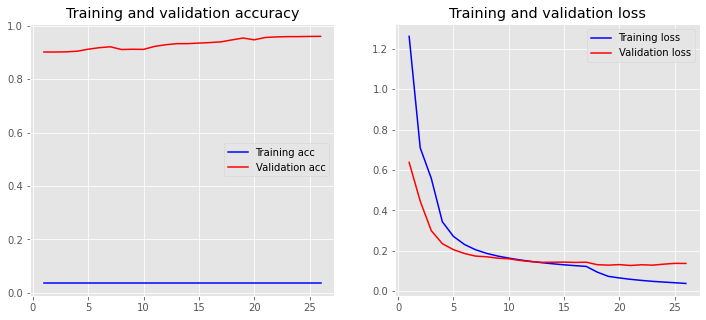

27625/27625 [==============================] - 62s 2ms/step
F1-score: 52.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.4791961115515874,0.3177792713091107,0.3821412666384434,218721.0
test,0.806719925310587,0.7251616471799958,0.7637696808377068,104858.0
treatment,0.48754659905854103,0.5954972988616631,0.5361420407170651,414640.0
micro avg,0.5262634931277238,0.5316322121213353,0.5289342297581688,738219.0
macro avg,0.5911542119735719,0.5461460724502566,0.5606843293977385,738219.0
weighted avg,0.5304084729281225,0.5316322121213353,0.5228470371754602,738219.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_8 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 124s 19ms/

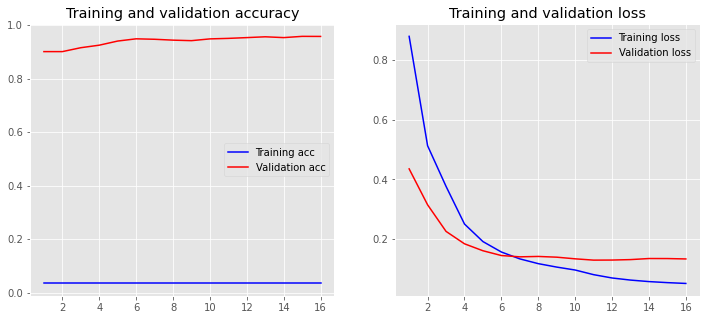

27625/27625 [==============================] - 64s 2ms/step
F1-score: 57.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.6090923731376701,0.7089717036772875,0.6552477456539927,218721.0
test,0.39157434604621044,0.3229224284270156,0.3539502017435662,104858.0
treatment,0.5397821105050381,0.6140724483889639,0.5745357066701866,414640.0
micro avg,0.5457239950391748,0.6008338988836646,0.5719545038095097,738219.0
macro avg,0.5134829432296395,0.548655526831089,0.5279112180225819,738219.0
weighted avg,0.5392657870124812,0.6008338988836646,0.5671168553577461,738219.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 204)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 204, 7)            1407      
_________________________________________________________________
crf_9 (CRF)                  (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 129s 20ms/

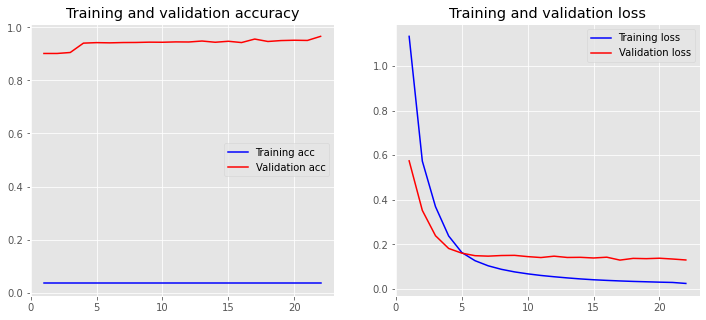

27625/27625 [==============================] - 65s 2ms/step
F1-score: 53.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.49012254102008723,0.37761806136584963,0.42657707444555776,218721.0
test,0.3899249907775546,0.7257815331209827,0.5073025057160189,104858.0
treatment,0.6135464200621895,0.5862724290951187,0.5995994317060658,414640.0
micro avg,0.5287400036057424,0.5442680288640633,0.5363916594019964,738219.0
macro avg,0.4978646506199438,0.5632240078606503,0.5111596706225475,738219.0
weighted avg,0.545214542828068,0.5442680288640633,0.5352259950052495,738219.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 204)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 204, 100)          2839100   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 204, 200)          160800    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 204, 7)            1407      
_________________________________________________________________
crf_10 (CRF)                 (None, 204, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 6526 samples, validate on 3263 samples
Epoch 1/100
6526/6526 [==============================] - 132s 20ms

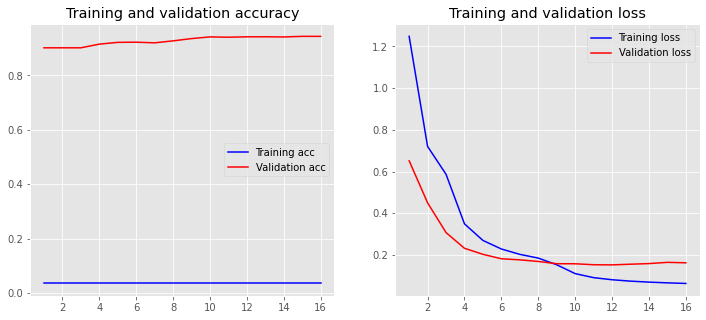

27625/27625 [==============================] - 65s 2ms/step
F1-score: 53.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.3940267163048212,0.3019554592380247,0.3419010493510796,218721.0
test,0.6278295088757907,0.6938049552728451,0.6591704985616236,104858.0
treatment,0.5383226881421828,0.6545195832529423,0.5907616622042273,414640.0
micro avg,0.5207838705991392,0.5556413476217762,0.537648220761032,738219.0
macro avg,0.5200596377742649,0.5500933325879375,0.5306110700389769,738219.0
weighted avg,0.5082841046760909,0.5556413476217762,0.5267456610702962,738219.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 222)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 222, 100)          2839100   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 222, 200)          160800    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 222, 7)            1407      
_________________________________________________________________
crf_11 (CRF)                 (None, 222, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 169s 21ms

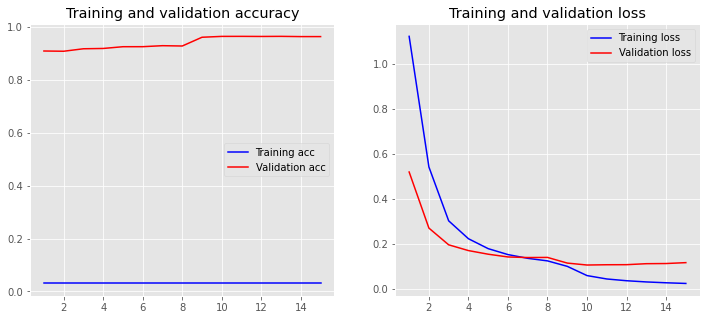

27625/27625 [==============================] - 70s 3ms/step
F1-score: 64.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.5356213661826001,0.7379355434549038,0.6207088838338874,218721.0
test,0.7465722808585946,0.7804840832363769,0.7631516372232248,104858.0
treatment,0.5962385646843261,0.6560896199112483,0.6247338965807864,414640.0
micro avg,0.5941786330788417,0.6980083146058284,0.6419220175428761,738219.0
macro avg,0.6261440705751736,0.7248364155341763,0.6695314725459661,738219.0
weighted avg,0.5996324607193854,0.6980083146058284,0.6432024711301685,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 221)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 221, 100)          2839100   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 221, 200)          160800    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 221, 7)            1407      
_________________________________________________________________
crf_12 (CRF)                 (None, 221, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 170s 21ms

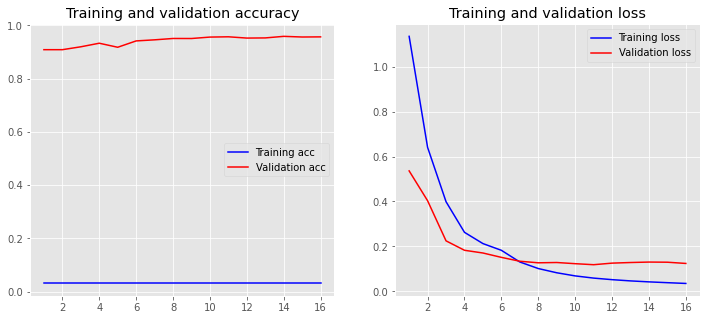

27625/27625 [==============================] - 69s 3ms/step
F1-score: 61.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.5902758116053405,0.7339578732723424,0.6543219437436057,218721.0
test,0.6295865353393224,0.6656716702588262,0.6471264474379537,104858.0
treatment,0.5729857569127631,0.6006608142002701,0.586496991076254,414640.0
micro avg,0.5864138784776929,0.6493885960670207,0.6162966867324671,738219.0
macro avg,0.597616034619142,0.6667634525771463,0.6293151274192711,738219.0
weighted avg,0.5861481687128758,0.6493885960670207,0.615204224305866,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 219)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 219, 100)          2839100   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 219, 200)          160800    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 219, 7)            1407      
_________________________________________________________________
crf_13 (CRF)                 (None, 219, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 164s 20ms

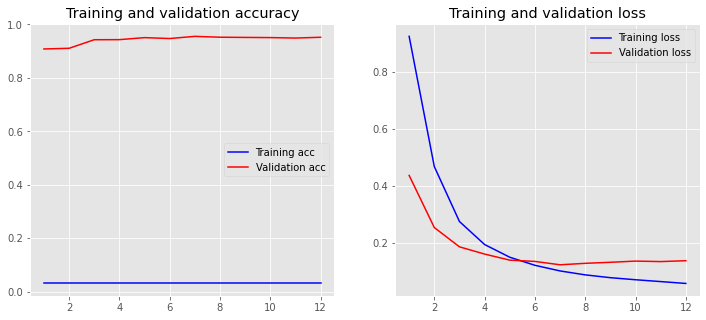

27625/27625 [==============================] - 68s 2ms/step
F1-score: 56.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.5259052035710597,0.7683898665423073,0.6244329264894388,218721.0
test,0.7159809931801955,0.27733696999752044,0.39980752706650624,104858.0
treatment,0.5388165962286154,0.5838968743970674,0.5604516818272836,414640.0
micro avg,0.542608740767643,0.5950144875707615,0.5676045527144165,738219.0
macro avg,0.5935675976599569,0.5432079036456318,0.5282307117944095,738219.0
weighted avg,0.5601559435254142,0.5950144875707615,0.5565899782323418,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 220)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 220, 100)          2839100   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 220, 200)          160800    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 220, 7)            1407      
_________________________________________________________________
crf_14 (CRF)                 (None, 220, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 168s 21ms

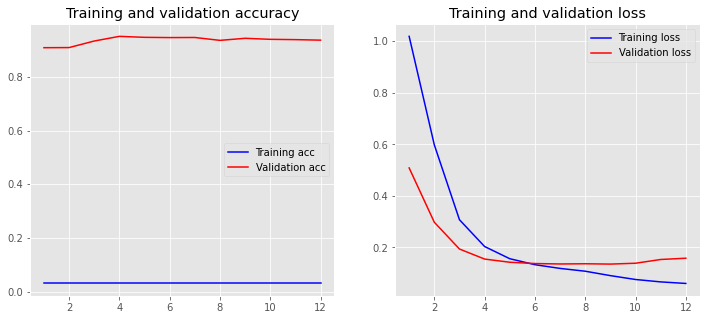

27625/27625 [==============================] - 68s 2ms/step
F1-score: 44.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.3837584645022454,0.27231953036059636,0.3185746988725102,218721.0
test,0.3253244511241546,0.15275896927273075,0.20789772542911839,104858.0
treatment,0.4525172399777811,0.6444289021802045,0.5316855166705136,414640.0
micro avg,0.4312142422244922,0.4643418822869636,0.4471653477054771,738219.0
macro avg,0.38720005186806034,0.3565024672711772,0.3527193136573807,738219.0
weighted avg,0.41407855229242185,0.4643418822869636,0.422553197679012,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 221)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 221, 100)          2839100   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 221, 200)          160800    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 221, 7)            1407      
_________________________________________________________________
crf_15 (CRF)                 (None, 221, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 166s 20ms

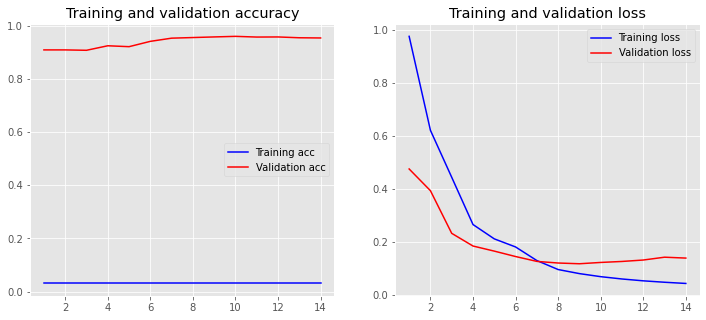

27625/27625 [==============================] - 69s 3ms/step
F1-score: 59.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.5656271466823681,0.7378669629345147,0.6403674275114325,218721.0
test,0.46969736464822875,0.34368383909668315,0.3969292448673892,104858.0
treatment,0.5756156057425625,0.6587039359444338,0.6143632216588762,414640.0
micro avg,0.562494172438443,0.6374124751598103,0.5976144951519627,738219.0
macro avg,0.5369800390243865,0.5800849126585439,0.550553298012566,738219.0
weighted avg,0.5576113811442056,0.6374124751598103,0.5911830731797327,738219.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 221)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 221, 100)          2839100   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 221, 200)          160800    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 221, 7)            1407      
_________________________________________________________________
crf_16 (CRF)                 (None, 221, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 166s 20ms

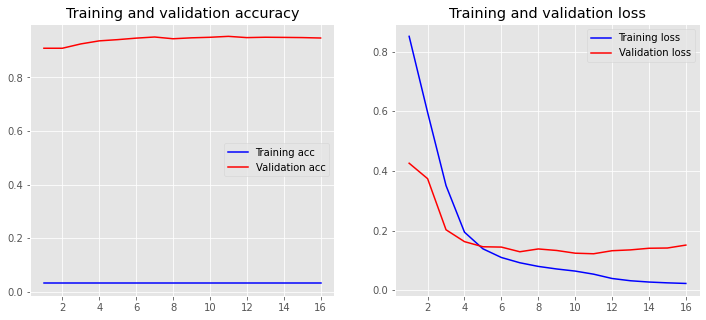

27625/27625 [==============================] - 71s 3ms/step
F1-score: 63.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.6196254566952912,0.6660631580872436,0.6420056672704116,218721.0
test,0.5854554450250006,0.7447977264491026,0.6555833036032821,104858.0
treatment,0.6068216022026646,0.6330575921281111,0.6196620188454534,414640.0
micro avg,0.6070215472420254,0.6587083236817259,0.6318096064694511,738219.0
macro avg,0.6039675013076522,0.6813061588881525,0.6390836632397157,738219.0
weighted avg,0.6075802650779716,0.6587083236817259,0.6313843657429075,738219.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 222)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 222, 100)          2839100   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 222, 200)          160800    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 222, 7)            1407      
_________________________________________________________________
crf_17 (CRF)                 (None, 222, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 165s 20ms

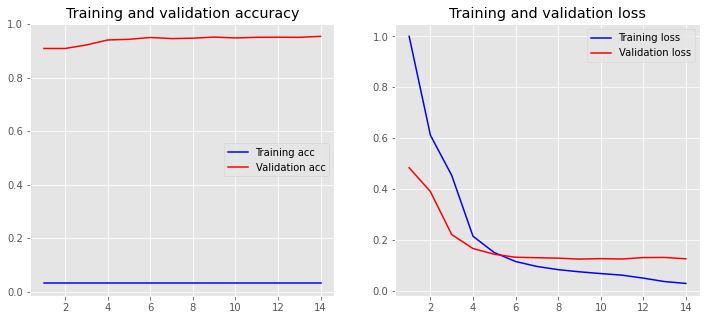

27625/27625 [==============================] - 70s 3ms/step
F1-score: 58.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.5930279460426133,0.759574983654976,0.6660479325192236,218721.0
test,0.5360035549092085,0.25307558793797325,0.34381700752103755,104858.0
treatment,0.5302739940939448,0.6439803202778314,0.5816219065532117,414640.0
micro avg,0.551714039848441,0.6227041027120678,0.5850635028311864,738219.0
macro avg,0.5531018316819222,0.5522102972902602,0.5304956155311576,738219.0
weighted avg,0.5496806978121255,0.6227041027120678,0.5728575679526018,738219.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 217)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 217, 100)          2839100   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 217, 200)          160800    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 217, 7)            1407      
_________________________________________________________________
crf_18 (CRF)                 (None, 217, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 165s 20ms

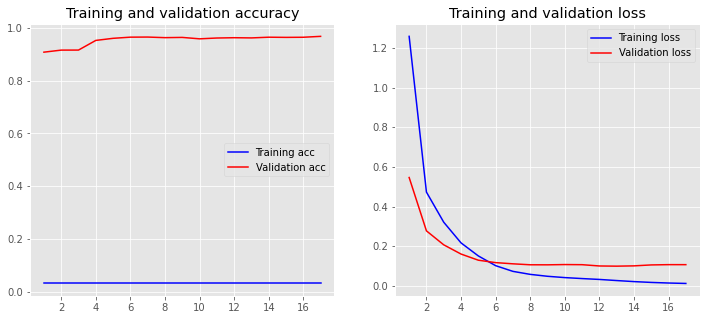

27625/27625 [==============================] - 71s 3ms/step
F1-score: 65.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.5753879703823918,0.7262082744683866,0.6420600962461575,218721.0
test,0.7351236359564884,0.8139865341700204,0.7725476885479601,104858.0
treatment,0.6156448671995784,0.642485047269921,0.6287786611782283,414640.0
micro avg,0.6189900057705643,0.6916511224988791,0.6533064209149155,738219.0
macro avg,0.6420521578461529,0.7275599519694427,0.6811288153241152,738219.0
weighted avg,0.6206884599621058,0.6916511224988791,0.6531349313791144,738219.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 220)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 220, 100)          2839100   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 220, 200)          160800    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 220, 7)            1407      
_________________________________________________________________
crf_19 (CRF)                 (None, 220, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 168s 21ms

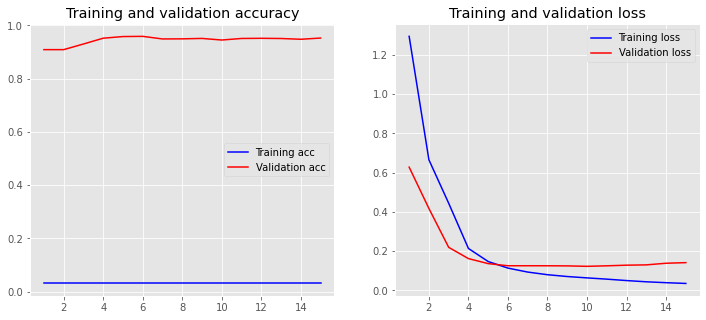

27625/27625 [==============================] - 72s 3ms/step
F1-score: 50.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.4713743542662072,0.3333333333333333,0.39051393984841587,218721.0
test,0.3193257235141502,0.6373571878159034,0.42547962909320103,104858.0
treatment,0.5570547656544595,0.605674802238086,0.5803482500837696,414640.0
micro avg,0.47972606438468807,0.5294851527798662,0.5033789243977337,738219.0
macro avg,0.44925161447827233,0.5254551077957742,0.46544727300846217,738219.0
weighted avg,0.4979017268407762,0.5294851527798662,0.5021059344175298,738219.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 219)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 219, 100)          2839100   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 219, 200)          160800    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 219, 7)            1407      
_________________________________________________________________
crf_20 (CRF)                 (None, 219, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 8158 samples, validate on 3263 samples
Epoch 1/100
8158/8158 [==============================] - 168s 21ms

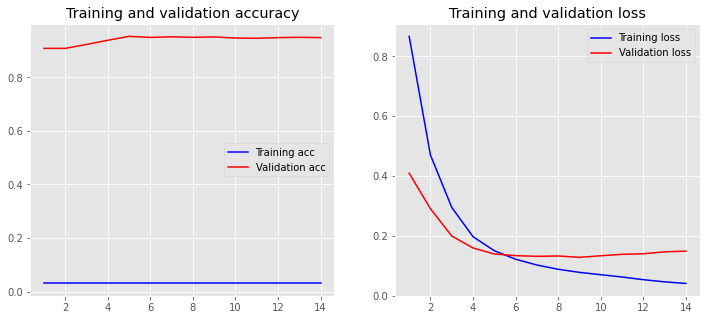

27625/27625 [==============================] - 73s 3ms/step
F1-score: 58.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.5782034148907435,0.7437831758267381,0.6506238039341942,218721.0
test,0.463007935157543,0.2854622441778405,0.35317715492575524,104858.0
treatment,0.5414439752401004,0.642574281304264,0.5876902173313658,414640.0
micro avg,0.5477340766098192,0.6218357966944769,0.5824374647118905,738219.0
macro avg,0.5275517750961289,0.5572732337696142,0.5304970587304384,738219.0
weighted avg,0.5411939344105517,0.6218357966944769,0.5730256344604695,738219.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 227)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 227, 100)          2839100   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 227, 200)          160800    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 227, 7)            1407      
_________________________________________________________________
crf_21 (CRF)                 (None, 227, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 208s 21ms

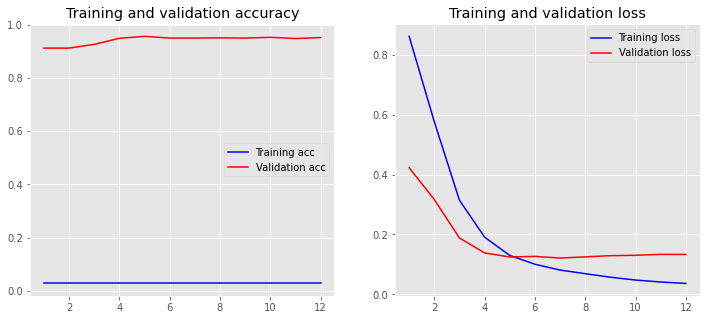

27625/27625 [==============================] - 76s 3ms/step
F1-score: 58.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.6146982297018831,0.7269352279845099,0.6661220248943185,218721.0
test,0.5236481426003595,0.26671307863968413,0.3534176639328725,104858.0
treatment,0.5327828334805474,0.6342562222650975,0.5791080008631966,414640.0
micro avg,0.5584756670477127,0.609508831390143,0.5828773440698078,738219.0
macro avg,0.5570430685942633,0.5426348429630972,0.5328825632301292,738219.0
weighted avg,0.5557553822236875,0.609508831390143,0.5728312144356881,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 224)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 224, 100)          2839100   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 224, 200)          160800    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 224, 7)            1407      
_________________________________________________________________
crf_22 (CRF)                 (None, 224, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 209s 21ms

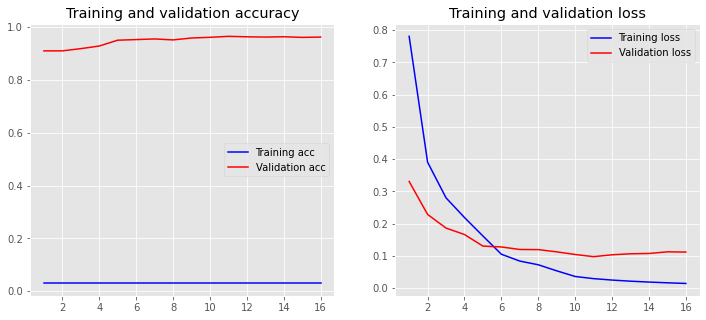

27625/27625 [==============================] - 74s 3ms/step
F1-score: 63.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.6003264384648239,0.7197297013089735,0.6546278680514402,218721.0
test,0.6614821890742237,0.7726544469663735,0.7127593593708076,104858.0
treatment,0.5687908475187123,0.6242185992668339,0.5952171243414288,414640.0
micro avg,0.5921576753108957,0.6736009233032474,0.6302591304017187,738219.0
macro avg,0.6101998250192534,0.7055342491807269,0.6542014505878923,738219.0
weighted avg,0.5913003259799173,0.6736009233032474,0.6295153758842745,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 223)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 223, 100)          2839100   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 223, 200)          160800    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 223, 7)            1407      
_________________________________________________________________
crf_23 (CRF)                 (None, 223, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 205s 21ms

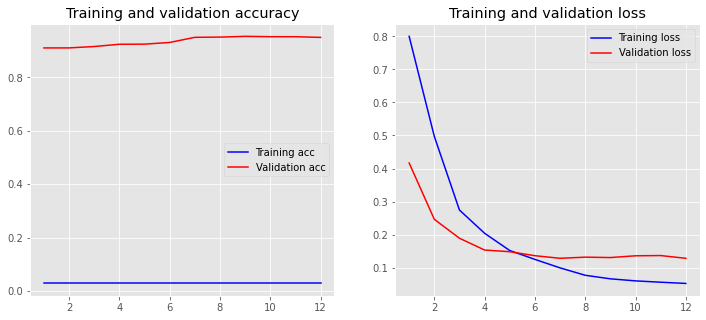

27625/27625 [==============================] - 74s 3ms/step
F1-score: 53.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.5209541313412779,0.6026124606233512,0.5588159228026439,218721.0
test,0.5287105489741991,0.33964981212687634,0.4135988851469051,104858.0
treatment,0.5026819783986548,0.5998432375072352,0.5469813860201622,414640.0
micro avg,0.5105041887944688,0.5637053503093256,0.5357873526590575,738219.0
macro avg,0.5174488862380439,0.5140351700858209,0.5064653979899038,738219.0
weighted avg,0.5117928349563617,0.5637053503093256,0.5315418476758947,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 219)               0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 219, 100)          2839100   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 219, 200)          160800    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 219, 7)            1407      
_________________________________________________________________
crf_24 (CRF)                 (None, 219, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 203s 21ms

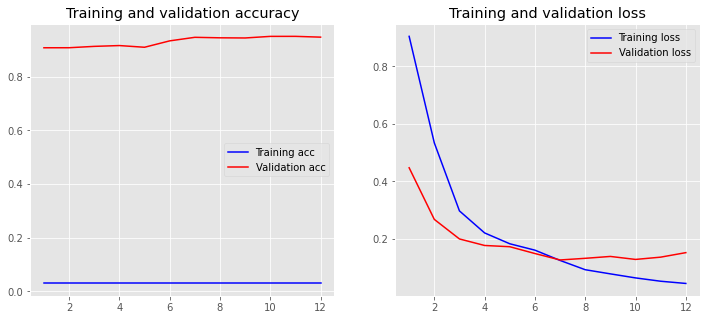

27625/27625 [==============================] - 73s 3ms/step
F1-score: 46.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.47680690399137,0.3718344374797116,0.4178283999804772,218721.0
test,0.2148367490064677,0.02629270060462721,0.0468515009643898,104858.0
treatment,0.47509979898643867,0.6070687825583638,0.5330375719330196,414640.0
micro avg,0.47082510768126346,0.4548785658456366,0.46271448600867415,738219.0
macro avg,0.38891448399475875,0.33506530688090086,0.33257249095929553,738219.0
weighted avg,0.43863733570519525,0.4548785658456366,0.42984439439591937,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 221)               0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 221, 100)          2839100   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 221, 200)          160800    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 221, 7)            1407      
_________________________________________________________________
crf_25 (CRF)                 (None, 221, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 207s 21ms

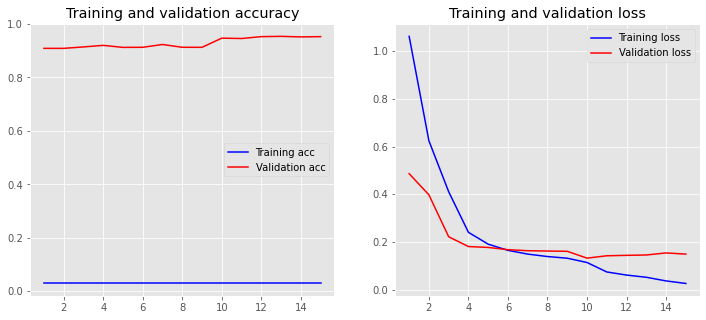

27625/27625 [==============================] - 74s 3ms/step
F1-score: 54.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.4778002533927681,0.7052043470905858,0.5696458248698157,218721.0
test,0.3063232367897413,0.13213107249804498,0.18462501998827355,104858.0
treatment,0.5512467967571683,0.6531617788925332,0.5978923525756148,414640.0
micro avg,0.51076513822107,0.5945728841983206,0.5494918210003086,738219.0
macro avg,0.4451234289798925,0.4968323994937213,0.45072106581123467,738219.0
weighted avg,0.4946965101047393,0.5945728841983206,0.5308221542377455,738219.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 223)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 223, 100)          2839100   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 223, 200)          160800    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 223, 7)            1407      
_________________________________________________________________
crf_26 (CRF)                 (None, 223, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 207s 21ms

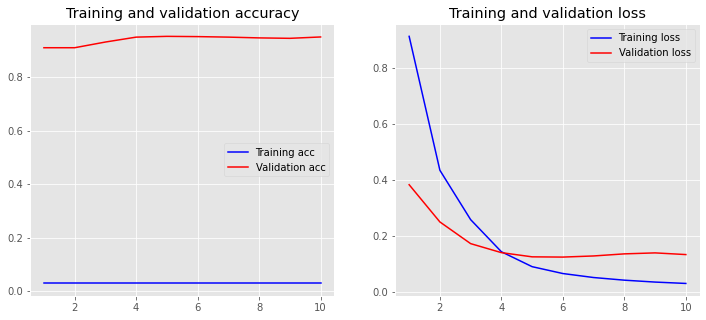

27625/27625 [==============================] - 75s 3ms/step
F1-score: 59.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.5998383804340749,0.7160812176242793,0.6528255958385089,218721.0
test,0.45388440575993017,0.6345629327280703,0.5292276611905813,104858.0
treatment,0.5546359490414706,0.5907172486976654,0.5721082762825049,414640.0
micro avg,0.5511420901427024,0.6340882583623559,0.589712756662986,738219.0
macro avg,0.5361195784118252,0.647120466350005,0.584720511103865,738219.0
weighted avg,0.5537176790852734,0.6340882583623559,0.5899325226285076,738219.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 224)               0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 224, 100)          2839100   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 224, 200)          160800    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 224, 7)            1407      
_________________________________________________________________
crf_27 (CRF)                 (None, 224, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 206s 21ms

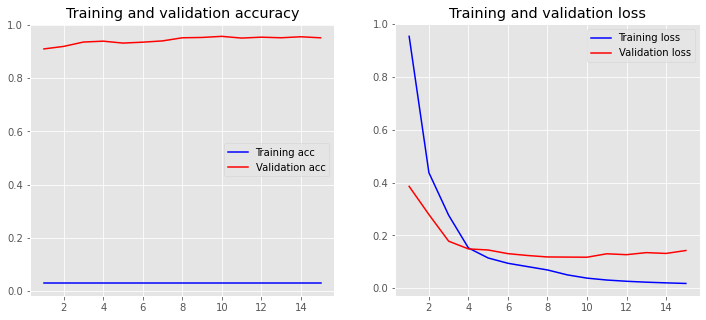

27625/27625 [==============================] - 76s 3ms/step
F1-score: 63.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.6054622712128106,0.7543994403829536,0.6717747763336014,218721.0
test,0.7382469676924165,0.6971237292338209,0.7170962599632128,104858.0
treatment,0.5759292874216918,0.6037381825197762,0.5895059584293436,414640.0
micro avg,0.6058481621231403,0.6616410577348998,0.632516651871478,738219.0
macro avg,0.6398795087756396,0.6850871173788503,0.6594589982420526,738219.0
weighted avg,0.6077352841050675,0.6616410577348998,0.6320038919139541,738219.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 228)               0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 228, 100)          2839100   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 228, 200)          160800    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 228, 7)            1407      
_________________________________________________________________
crf_28 (CRF)                 (None, 228, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 213s 22ms

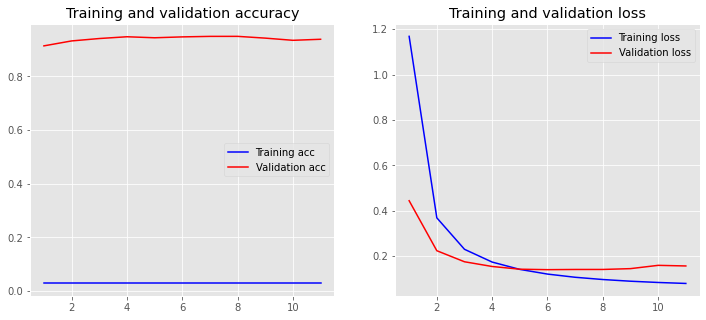

27625/27625 [==============================] - 78s 3ms/step
F1-score: 43.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.4677609801044262,0.3133398256225968,0.37528611637407044,218721.0
test,0.32193281839410814,0.1709168589902535,0.22328814910794378,104858.0
treatment,0.4123263523212972,0.6137540999421185,0.49326929227262417,414640.0
micro avg,0.41609723413836996,0.46184533315994303,0.4377793557019059,738219.0
macro avg,0.40067338360661053,0.3660035948516563,0.36394785258487944,738219.0
weighted avg,0.41591096886844175,0.46184533315994303,0.4199643774361466,738219.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 222)               0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 222, 100)          2839100   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 222, 200)          160800    
_________________________________________________________________
time_distributed_29 (TimeDis (None, 222, 7)            1407      
_________________________________________________________________
crf_29 (CRF)                 (None, 222, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 208s 21ms

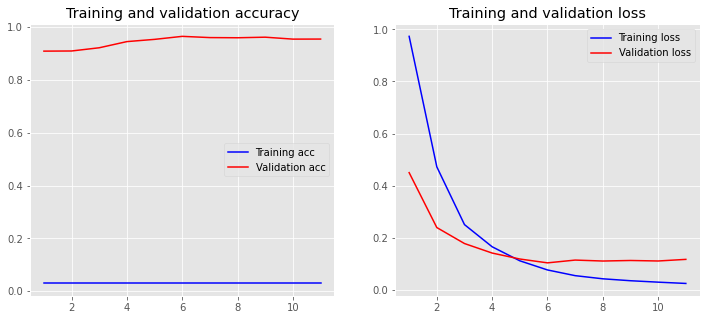

27625/27625 [==============================] - 77s 3ms/step
F1-score: 64.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.6351858165700648,0.7580753562758035,0.6912109855385424,218721.0
test,0.7760845373529656,0.8047645387094928,0.7901643795852822,104858.0
treatment,0.5555280946909985,0.6017292108817287,0.5777064105473255,414640.0
micro avg,0.6102059607226332,0.6768912748114042,0.641821113817687,738219.0
macro avg,0.655599482871343,0.7215230352890084,0.6863605918903835,738219.0
weighted avg,0.6104574910513737,0.6768912748114042,0.6415136979024817,738219.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 220)               0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 220, 100)          2839100   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 220, 200)          160800    
_________________________________________________________________
time_distributed_30 (TimeDis (None, 220, 7)            1407      
_________________________________________________________________
crf_30 (CRF)                 (None, 220, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 9789 samples, validate on 3263 samples
Epoch 1/100
9789/9789 [==============================] - 206s 21ms

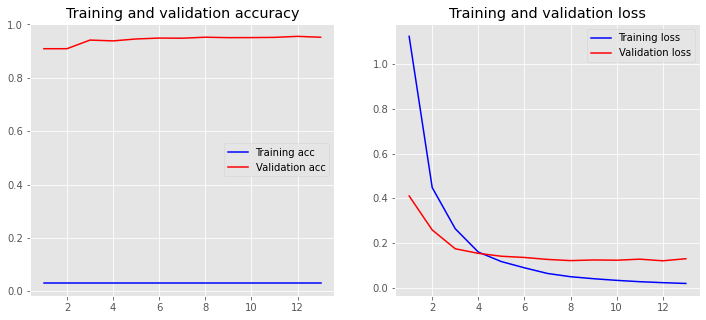

27625/27625 [==============================] - 78s 3ms/step
F1-score: 60.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6482030273410879,0.7610334627219152,0.7001013639976952,218721.0
test,0.6367687102896279,0.7359476625531671,0.6827753397508495,104858.0
treatment,0.4818182869522646,0.6028747829442408,0.5355913174454555,414640.0
micro avg,0.5504008135584149,0.6686362718922163,0.6037846631845483,738219.0
macro avg,0.5889300081943268,0.699951969406441,0.6394893403980001,738219.0
weighted avg,0.5531245365785856,0.6686362718922163,0.6052389749872573,738219.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 227)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 227, 100)          2839100   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 227, 200)          160800    
_________________________________________________________________
time_distributed_31 (TimeDis (None, 227, 7)            1407      
_________________________________________________________________
crf_31 (CRF)                 (None, 227, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 242s 2

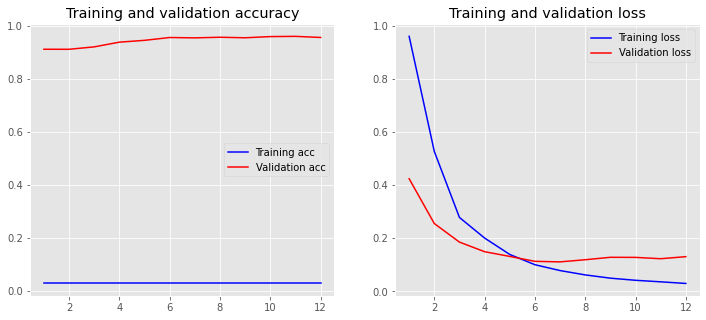

27625/27625 [==============================] - 77s 3ms/step
F1-score: 57.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.5687123740066737,0.755844203345815,0.649059403899798,218721.0
test,0.5440134699492823,0.2526655095462435,0.3450660658118378,104858.0
treatment,0.5324543406143812,0.6371551225159174,0.5801184435021859,414640.0
micro avg,0.5457421026491057,0.617706940623311,0.5794988384683032,738219.0
macro avg,0.5483933948567791,0.548554945135992,0.5247479710712738,738219.0
weighted avg,0.5448388234106716,0.617706940623311,0.5671571319933675,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 225)               0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 225, 100)          2839100   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 225, 200)          160800    
_________________________________________________________________
time_distributed_32 (TimeDis (None, 225, 7)            1407      
_________________________________________________________________
crf_32 (CRF)                 (None, 225, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 241s 2

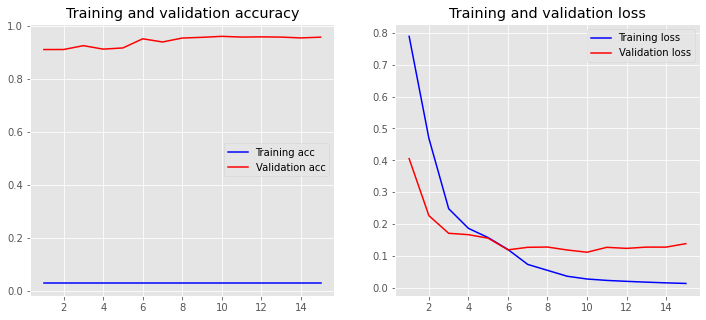

27625/27625 [==============================] - 77s 3ms/step
F1-score: 64.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.607646435339336,0.7784712030394887,0.6825326198063857,218721.0
test,0.7088547566983692,0.7697838982242652,0.7380639970008549,104858.0
treatment,0.5806395650149768,0.6376784680686861,0.6078238001314925,414640.0
micro avg,0.6067358720681097,0.6981573218787379,0.6492440814249298,738219.0
macro avg,0.632380252350894,0.7286445231108134,0.6761401389795777,738219.0
weighted avg,0.6068531388375841,0.6981573218787379,0.6484582383015206,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 224)               0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 224, 100)          2839100   
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 224, 200)          160800    
_________________________________________________________________
time_distributed_33 (TimeDis (None, 224, 7)            1407      
_________________________________________________________________
crf_33 (CRF)                 (None, 224, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 239s 2

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 228)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 228, 100)          2839100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 228, 200)          160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 228, 7)            1407      
_________________________________________________________________
crf_1 (CRF)                  (None, 228, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________

Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 233s 2

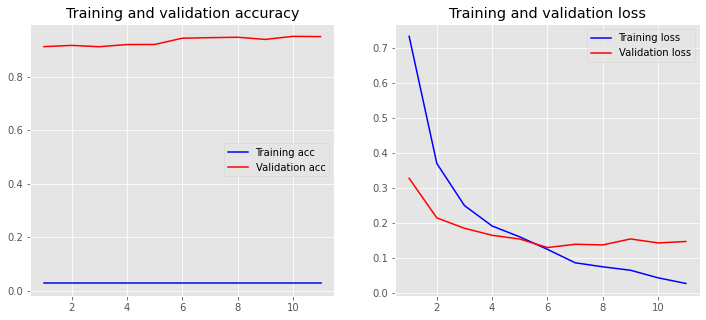

27625/27625 [==============================] - 71s 3ms/step
F1-score: 53.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.5957342503321515,0.7667210738795086,0.67049832173508,218721.0
test,0.17419043015949734,0.0171851456255126,0.03128390753713011,104858.0
treatment,0.45723149287647674,0.6245393594443372,0.5279474170823126,414640.0
micro avg,0.499249597416005,0.5803955194867648,0.5367731024006764,738219.0
macro avg,0.4090520577893752,0.4694818596497862,0.4099098821181742,738219.0
weighted avg,0.45806368746789966,0.5803955194867648,0.4996356750825391,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 228)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 228, 100)          2839100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 228, 200)          160800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 228, 7)            1407      
_________________________________________________________________
crf_2 (CRF)                  (None, 228, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 244s 21

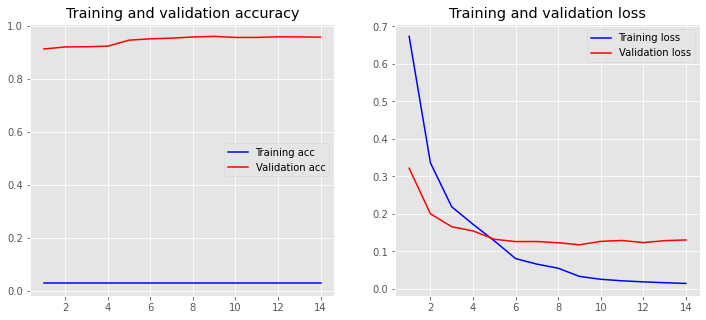

27625/27625 [==============================] - 72s 3ms/step
F1-score: 63.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.5890988324107801,0.7342504834926687,0.6537141740648927,218721.0
test,0.7060899086418341,0.7061168437315226,0.7061033759298112,104858.0
treatment,0.5821174769961277,0.6138023345552769,0.5975401743736272,414640.0
micro avg,0.6004107113923927,0.6626014773393804,0.629974956581319,738219.0
macro avg,0.6257687393495807,0.6847232205931562,0.6524525747894437,738219.0
weighted avg,0.6017952017297822,0.6626014773393804,0.6296040383154272,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 223)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 223, 100)          2839100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 223, 200)          160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 223, 7)            1407      
_________________________________________________________________
crf_3 (CRF)                  (None, 223, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 239s 21

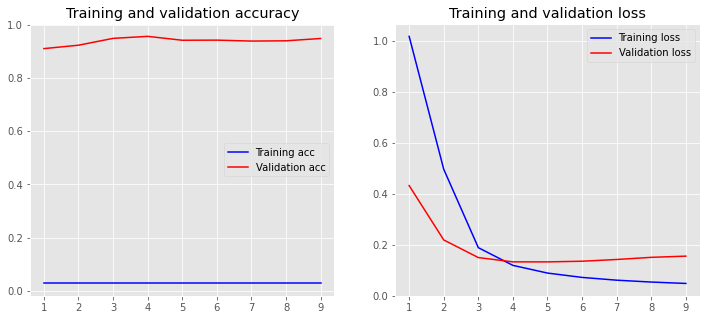

27625/27625 [==============================] - 69s 3ms/step
F1-score: 50.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.48254313367933793,0.3145605588855208,0.3808514230516938,218721.0
test,0.26915062134162354,0.606029106029106,0.37275340215861097,104858.0
treatment,0.5936208565151383,0.6242668338799923,0.6085582694437196,414640.0
micro avg,0.48015288538015144,0.5299159192597319,0.5038085652633348,738219.0
macro avg,0.44843820384536653,0.5149521662648731,0.4540543648846748,738219.0
weighted avg,0.5146221711166407,0.5299159192597319,0.5075986681282669,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 221)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 221, 100)          2839100   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 221, 200)          160800    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 221, 7)            1407      
_________________________________________________________________
crf_4 (CRF)                  (None, 221, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 227s 20

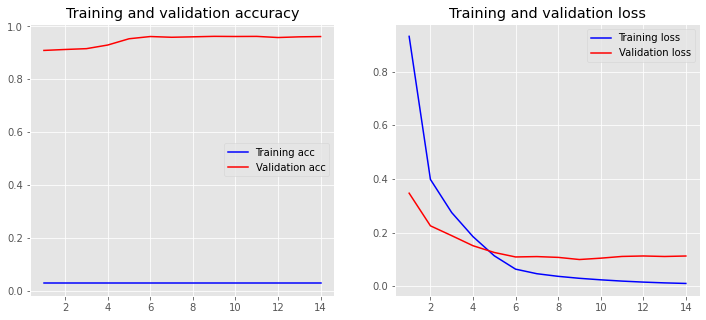

27625/27625 [==============================] - 68s 2ms/step
F1-score: 64.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.583527191084141,0.7236616511446089,0.6460830095026614,218721.0
test,0.7380990619066063,0.7451029010662038,0.7415844450455837,104858.0
treatment,0.5957671215204141,0.6348302141616824,0.614678674134555,414640.0
micro avg,0.6101105470939412,0.6768127073402337,0.6417330166856544,738219.0
macro avg,0.6391311248370538,0.7011982554574985,0.6674487095609334,738219.0
weighted avg,0.61235774405934,0.6768127073402337,0.6420091451224818,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 226)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 226, 100)          2839100   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 226, 200)          160800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 226, 7)            1407      
_________________________________________________________________
crf_5 (CRF)                  (None, 226, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 239s 21

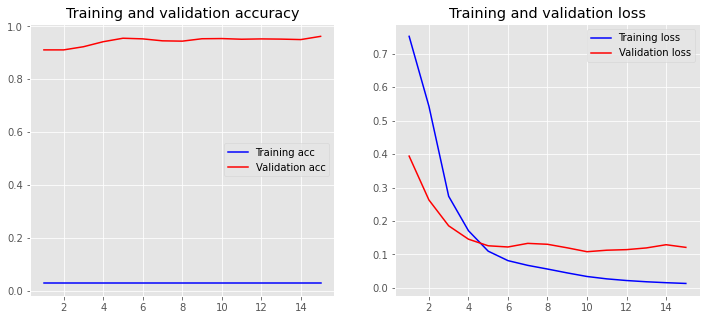

27625/27625 [==============================] - 71s 3ms/step
F1-score: 65.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.5258692408255972,0.7282794061841341,0.6107405838249023,218721.0
test,0.7712157324006149,0.7128402220145339,0.7408798735249951,104858.0
treatment,0.6754147458372091,0.6374348832722362,0.6558754485311998,414640.0
micro avg,0.6298945968731712,0.6750611945777608,0.6516962517948544,738219.0
macro avg,0.6574999063544736,0.6928515038236348,0.6691653019603657,738219.0
weighted avg,0.6447148552185997,0.6750611945777608,0.6545769873057008,738219.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 223)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 223, 100)          2839100   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 223, 200)          160800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 223, 7)            1407      
_________________________________________________________________
crf_6 (CRF)                  (None, 223, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 230s 20

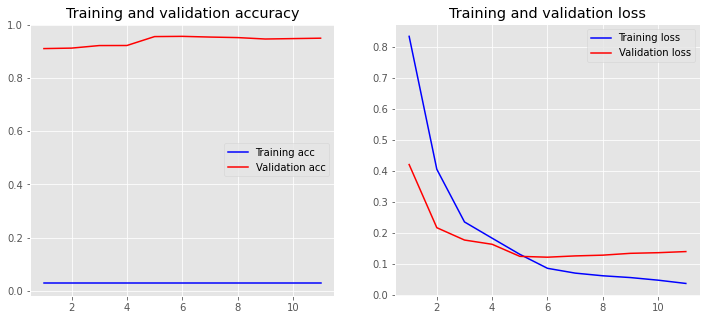

27625/27625 [==============================] - 71s 3ms/step
F1-score: 55.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.594323796742512,0.712707056021141,0.6481541925410957,218721.0
test,0.4046888864673008,0.24791622956760573,0.3074721310505929,104858.0
treatment,0.4957142634304611,0.6131439320856646,0.5482111128361712,414640.0
micro avg,0.5195612522918456,0.5907650710696961,0.5528800563891664,738219.0
macro avg,0.4982423155467579,0.5245890725581371,0.5012791454759533,738219.0
weighted avg,0.5120010790745207,0.5907650710696961,0.5436274353421872,738219.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 223)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 223, 100)          2839100   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 223, 200)          160800    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 223, 7)            1407      
_________________________________________________________________
crf_7 (CRF)                  (None, 223, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 237s 21

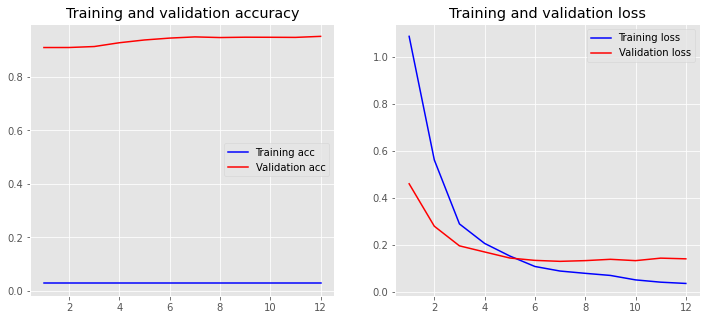

27625/27625 [==============================] - 73s 3ms/step
F1-score: 54.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.5751451911652928,0.7126750517782929,0.6365665257083818,218721.0
test,0.3507336135073361,0.045366114173453626,0.08034048015132451,104858.0
treatment,0.4925341153612188,0.6541602353849122,0.5619566061874254,414640.0
micro avg,0.5170359994732369,0.5850228726163916,0.5489323543748399,738219.0
macro avg,0.47280430667794926,0.47073380044555285,0.4262878706823772,738219.0
weighted avg,0.4968686828642883,0.5850228726163916,0.5156525317374988,738219.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 219)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 219, 100)          2839100   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 219, 200)          160800    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 219, 7)            1407      
_________________________________________________________________
crf_8 (CRF)                  (None, 219, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 11421 samples, validate on 3263 samples
Epoch 1/100
11421/11421 [==============================] - 234s 20

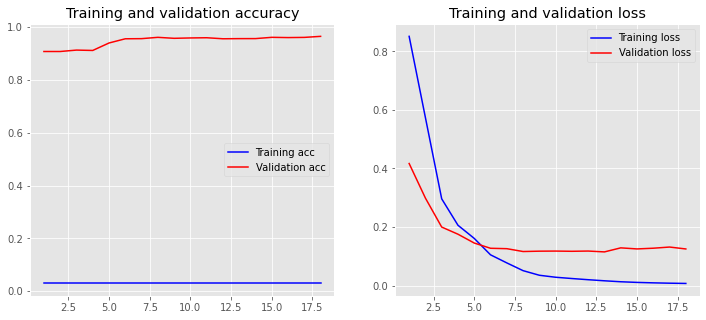

27625/27625 [==============================] - 71s 3ms/step
F1-score: 61.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.5629157805412087,0.7369937043082283,0.6382988833452126,218721.0
test,0.7230473129160591,0.6950447271548189,0.7087695412219496,104858.0
treatment,0.6009562949700008,0.5674344009261045,0.583714465404124,414640.0
micro avg,0.6027711460739957,0.6357977781660997,0.6188441319914615,738219.0
macro avg,0.6289731294757562,0.6664909441297172,0.6435942966570953,738219.0
weighted avg,0.6070276106681988,0.6357977781660997,0.6176499013880236,738219.0



In [ ]:
number_of_training_models = 8
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 223)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 223, 100)          2839100   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 223, 200)          160800    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 223, 7)            1407      
_________________________________________________________________
crf_9 (CRF)                  (None, 223, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 266s 20

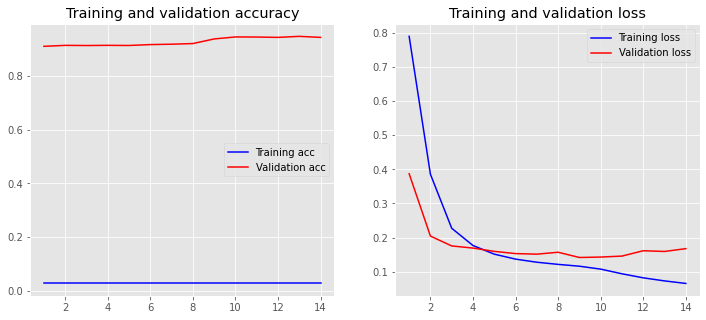

27625/27625 [==============================] - 71s 3ms/step
F1-score: 37.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.24628836598576523,0.15093200927208636,0.1871646081318974,218721.0
test,0.20181451612903226,0.10500867840317382,0.13813998419250023,104858.0
treatment,0.3845850280478401,0.6134309280339572,0.47277069915707104,414640.0
micro avg,0.351043804002033,0.4041835823786708,0.3757441661466817,738219.0
macro avg,0.2775626367208792,0.2897905385697391,0.26602509716048955,738219.0
weighted avg,0.31764915324420945,0.4041835823786708,0.34061918674019753,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 228)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 228, 100)          2839100   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 228, 200)          160800    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 228, 7)            1407      
_________________________________________________________________
crf_10 (CRF)                 (None, 228, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 269s 2

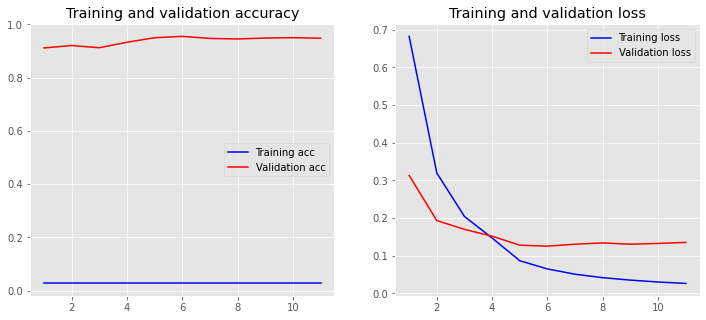

27625/27625 [==============================] - 73s 3ms/step
F1-score: 53.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.47739578330837973,0.46358602969079327,0.4703895712280946,218721.0
test,0.5276045276045276,0.6970188254591925,0.6005932962454702,104858.0
treatment,0.49221898150158067,0.6015579780050164,0.5414234642158661,414640.0
micro avg,0.49426351455341694,0.5742388098924573,0.5312581655217443,738219.0
macro avg,0.49907309747149603,0.5873876110516674,0.5374687772298103,738219.0
weighted avg,0.49285336352269865,0.5742388098924573,0.5287819935124324,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 222)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 222, 100)          2839100   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 222, 200)          160800    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 222, 7)            1407      
_________________________________________________________________
crf_11 (CRF)                 (None, 222, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 265s 2

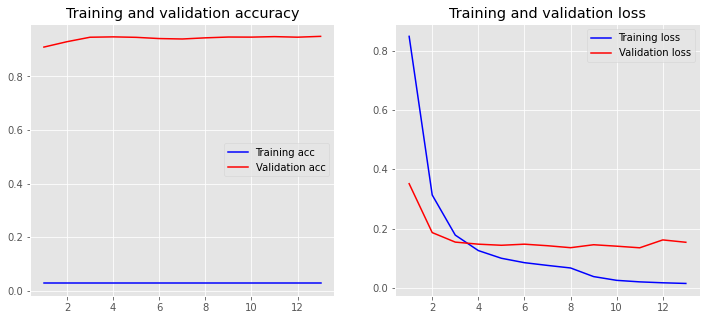

27625/27625 [==============================] - 70s 3ms/step
F1-score: 59.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.5670653429757371,0.7270495288518249,0.6371684607201457,218721.0
test,0.6720823682564371,0.3791127048007782,0.4847719914393898,104858.0
treatment,0.5513773734026346,0.6275853752652903,0.5870183365685792,414640.0
micro avg,0.5655961731355496,0.6217612930580221,0.5923503544131453,738219.0
macro avg,0.5968416948782695,0.5779158696392979,0.5696529295760383,738219.0
weighted avg,0.5731705983716188,0.6217612930580221,0.5873536544715298,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 224)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 224, 100)          2839100   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 224, 200)          160800    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 224, 7)            1407      
_________________________________________________________________
crf_12 (CRF)                 (None, 224, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 268s 2

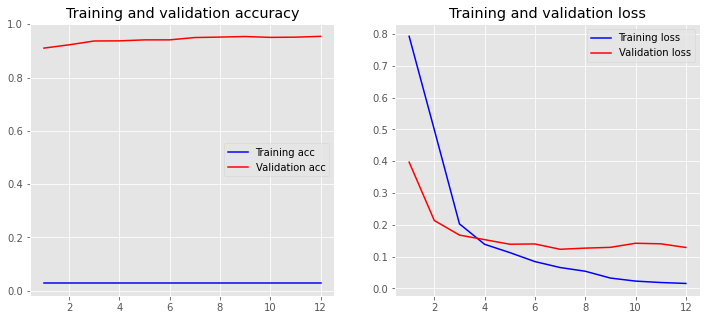

27625/27625 [==============================] - 72s 3ms/step
F1-score: 58.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.505762463954529,0.720900142190279,0.5944653898356206,218721.0
test,0.4966701650605858,0.24822140418470695,0.3310123805345186,104858.0
treatment,0.6029284793957078,0.6568203743005981,0.6287216826611199,414640.0
micro avg,0.5589741452640508,0.6177678981440466,0.5869022608158497,738219.0
macro avg,0.5351203694702743,0.5419806402251947,0.518066484343753,738219.0
weighted avg,0.5590468096095572,0.6177678981440466,0.5762849767168443,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 224)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 224, 100)          2839100   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 224, 200)          160800    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 224, 7)            1407      
_________________________________________________________________
crf_13 (CRF)                 (None, 224, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 262s 2

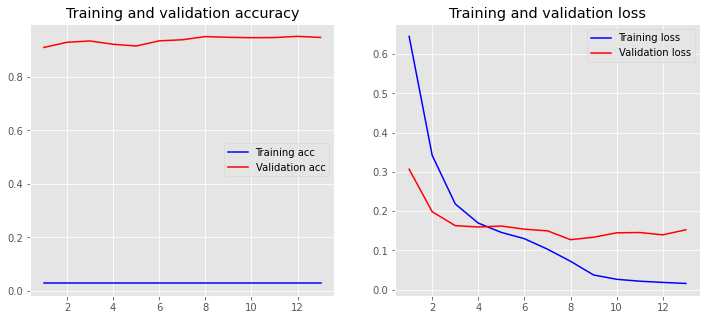

27625/27625 [==============================] - 72s 3ms/step
F1-score: 59.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.5454792030143534,0.6804193470220052,0.6055225420049679,218721.0
test,0.5786773228716635,0.6808445707528277,0.6256172528469213,104858.0
treatment,0.5586178894436488,0.6038877098205673,0.5803713601628034,414640.0
micro avg,0.5573035890014815,0.6374937518541246,0.5947076440928564,738219.0
macro avg,0.5609248051098885,0.6550505425318001,0.6038370516715642,738219.0
weighted avg,0.5575744124211024,0.6374937518541246,0.5942500133250376,738219.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 228)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 228, 100)          2839100   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 228, 200)          160800    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 228, 7)            1407      
_________________________________________________________________
crf_14 (CRF)                 (None, 228, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 265s 2

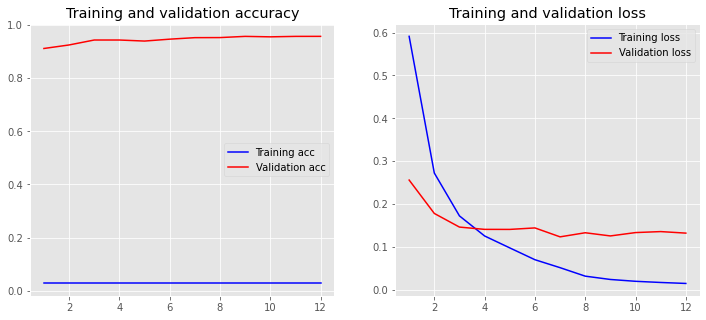

27625/27625 [==============================] - 73s 3ms/step
F1-score: 62.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.6428425140408504,0.7462429304913566,0.6906942742947338,218721.0
test,0.5531494664450033,0.7425089168208434,0.6339918245036887,104858.0
treatment,0.5525607708759745,0.6374131776963149,0.5919617269889905,414640.0
micro avg,0.5789140278749876,0.6845854685398235,0.6273308887603434,738219.0
macro avg,0.5828509171206094,0.7087216750028383,0.6388826085958044,738219.0
weighted avg,0.579393245503073,0.6845854685398235,0.6271844365703692,738219.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 225)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 225, 100)          2839100   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 225, 200)          160800    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 225, 7)            1407      
_________________________________________________________________
crf_15 (CRF)                 (None, 225, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 265s 2

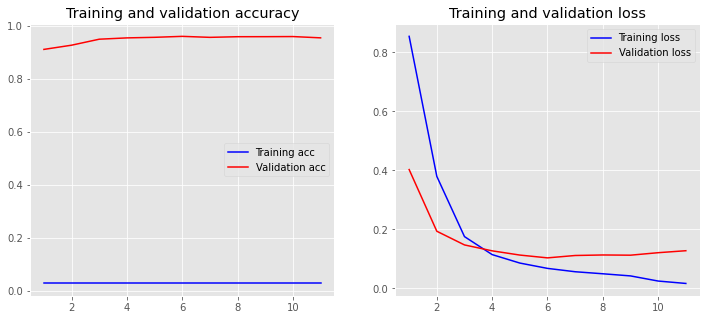

27625/27625 [==============================] - 73s 3ms/step
F1-score: 55.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.5696976624564211,0.7291846690532687,0.639649630118334,218721.0
test,0.5954091573307355,0.2797783669343302,0.3806786478946344,104858.0
treatment,0.4969281663516068,0.5883368705382983,0.5387829743625987,414640.0
micro avg,0.5276844328257753,0.5862393138079621,0.5554228657783369,738219.0
macro avg,0.5540116620462544,0.532433302175299,0.5197037507918557,738219.0
weighted avg,0.5324768811769236,0.5862393138079621,0.5462105159847628,738219.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 222)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 222, 100)          2839100   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 222, 200)          160800    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 222, 7)            1407      
_________________________________________________________________
crf_16 (CRF)                 (None, 222, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 278s 2

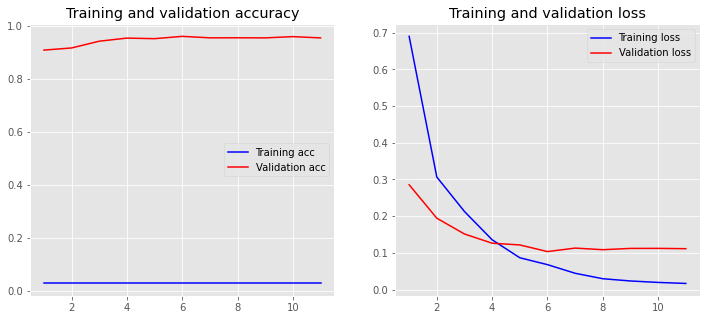

27625/27625 [==============================] - 72s 3ms/step
F1-score: 57.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.48390617441270517,0.37502114566045325,0.42256205776517347,218721.0
test,0.7739191086719102,0.8042018730092124,0.7887699409313486,104858.0
treatment,0.5207212901248756,0.6556989195446653,0.5804667150604211,414640.0
micro avg,0.5473871047119176,0.5936327837674186,0.5695727726562022,738219.0
macro avg,0.592848857736497,0.6116406460714437,0.5972662379189811,738219.0
weighted avg,0.5457783232458374,0.5936327837674186,0.5632701854534886,738219.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 220)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 220, 100)          2839100   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 220, 200)          160800    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 220, 7)            1407      
_________________________________________________________________
crf_17 (CRF)                 (None, 220, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 265s 2

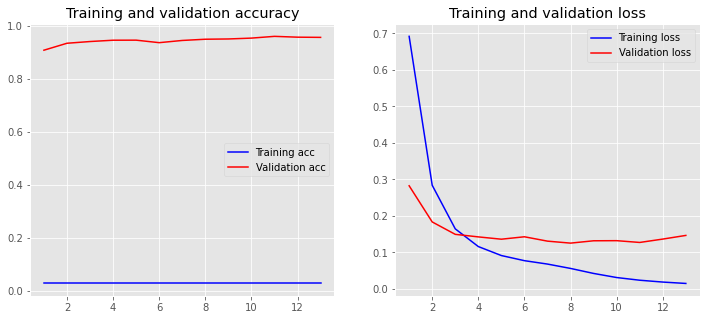

27625/27625 [==============================] - 72s 3ms/step
F1-score: 53.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.49932158748528443,0.45765152865979947,0.47757932579337725,218721.0
test,0.40804363026150187,0.6956836865093746,0.514383023132005,104858.0
treatment,0.555478118655014,0.5766689176152807,0.5658752002726312,414640.0
micro avg,0.5090224663178136,0.5583112870300005,0.5325288128585457,738219.0
macro avg,0.4876144454672668,0.5766680442614849,0.5192791830660045,738219.0
weighted avg,0.5178980804306641,0.5583112870300005,0.5324006775732849,738219.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 222)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 222, 100)          2839100   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 222, 200)          160800    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 222, 7)            1407      
_________________________________________________________________
crf_18 (CRF)                 (None, 222, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 13052 samples, validate on 3263 samples
Epoch 1/100
13052/13052 [==============================] - 266s 2

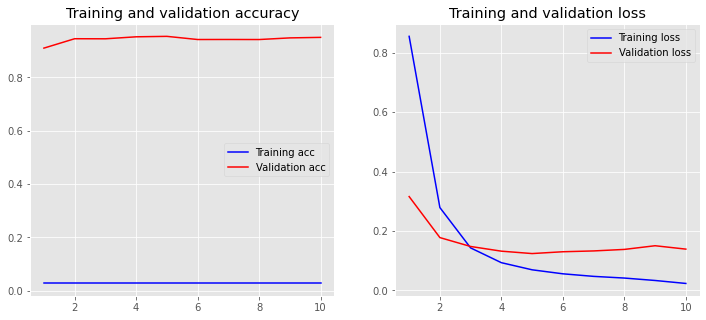

27625/27625 [==============================] - 75s 3ms/step
F1-score: 58.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.5440008833301547,0.7433442604962487,0.6282385672057035,218721.0
test,0.40138145358860355,0.33749451639359895,0.3666759918352968,104858.0
treatment,0.6187389752635681,0.5820181362145476,0.5998170683210053,414640.0
micro avg,0.5653320361512298,0.5950835727609287,0.5798264092370561,738219.0
macro avg,0.5213737707274421,0.554285637701465,0.5315772091206685,738219.0
weighted avg,0.5657215573786837,0.5950835727609287,0.5751220545912336,738219.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 228)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 228, 100)          2839100   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 228, 200)          160800    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 228, 7)            1407      
_________________________________________________________________
crf_19 (CRF)                 (None, 228, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 393s 2

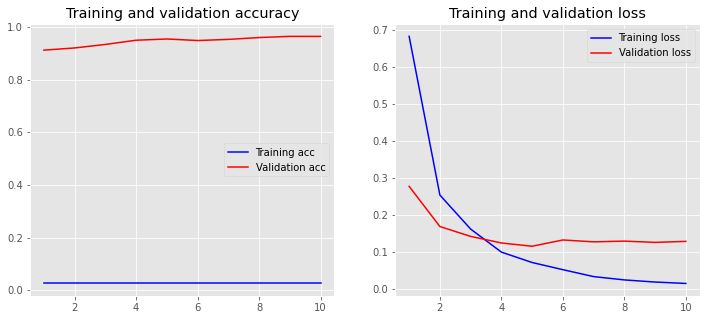

27625/27625 [==============================] - 77s 3ms/step
F1-score: 56.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.5990989136820677,0.7319781822504469,0.6589059869864227,218721.0
test,0.09462002227257017,0.023498445516794142,0.037647346427398226,104858.0
treatment,0.5437100518202475,0.6417205286513602,0.5886635753033105,414640.0
micro avg,0.5476798295040746,0.5806488318507109,0.56368266467308,738219.0
macro avg,0.41247632925829514,0.46573238547286705,0.4284056362390438,738219.0
weighted avg,0.4963311912612113,0.5806488318507109,0.5312077672006628,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 228)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 228, 100)          2839100   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 228, 200)          160800    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 228, 7)            1407      
_________________________________________________________________
crf_20 (CRF)                 (None, 228, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 404s 2

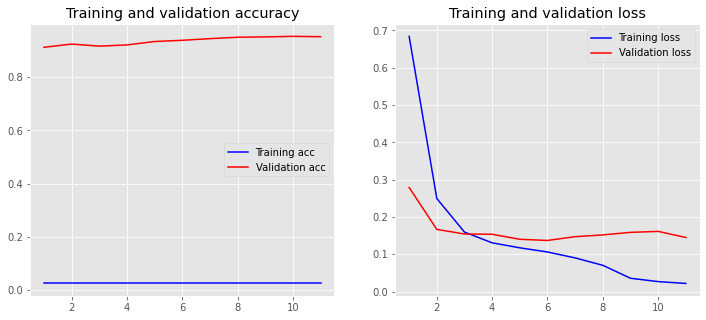

27625/27625 [==============================] - 76s 3ms/step
F1-score: 40.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.3625757849384691,0.32127230581425653,0.3406767088619869,218721.0
test,0.5120481927710844,0.01540178145682733,0.02990408473132615,104858.0
treatment,0.40167760514331635,0.5786079490642485,0.47417582417582416,414640.0
micro avg,0.3925745273148259,0.42236517889677727,0.4069253447729073,738219.0
macro avg,0.42543386095095664,0.30509401211177745,0.2815855392563791,738219.0
weighted avg,0.4057696833212664,0.42236517889677727,0.3715172553023206,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 222)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 222, 100)          2839100   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 222, 200)          160800    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 222, 7)            1407      
_________________________________________________________________
crf_21 (CRF)                 (None, 222, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 395s 2

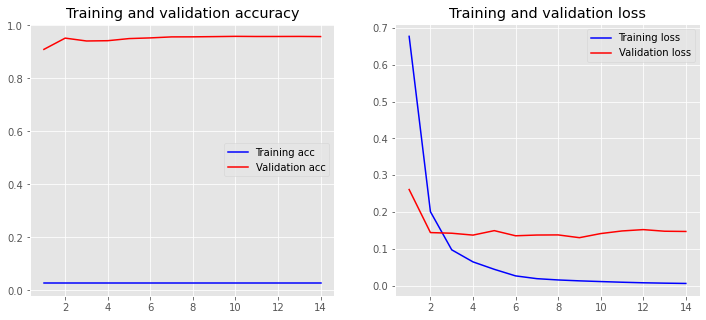

27625/27625 [==============================] - 75s 3ms/step
F1-score: 61.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.5276237677318152,0.713552882439272,0.6066621705405264,218721.0
test,0.6374500718964691,0.7609910545690363,0.6937636390509394,104858.0
treatment,0.6147670082661869,0.5685823847192746,0.5907734328994024,414640.0
micro avg,0.5862547329532882,0.6388646187648923,0.6114300715959512,738219.0
macro avg,0.5932802826314904,0.6810421072425276,0.630399747496956,738219.0
weighted avg,0.5921699794349402,0.6388646187648923,0.610109900292198,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 227)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 227, 100)          2839100   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 227, 200)          160800    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 227, 7)            1407      
_________________________________________________________________
crf_22 (CRF)                 (None, 227, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 396s 2

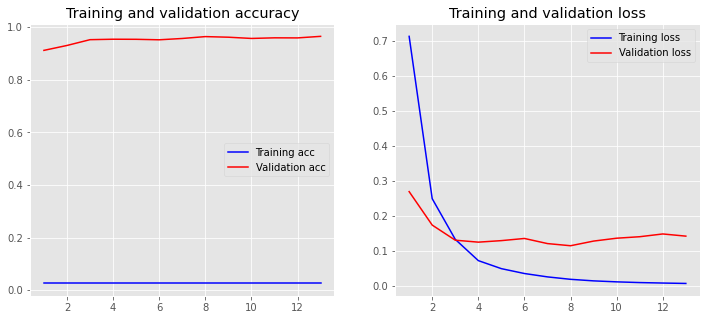

27625/27625 [==============================] - 78s 3ms/step
F1-score: 61.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.6545791088316197,0.7550669574480731,0.701241351198147,218721.0
test,0.5648409349070584,0.71607316561445,0.6315293682267201,104858.0
treatment,0.5491662518097656,0.5799754003472892,0.564150505195052,414640.0
micro avg,0.5840076877005296,0.6511834563997947,0.6157688977245362,738219.0
macro avg,0.5895287651828146,0.6837051744699374,0.6323070748733065,738219.0
weighted avg,0.5826246448081751,0.6511834563997947,0.6143386739477089,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 225)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 225, 100)          2839100   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 225, 200)          160800    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 225, 7)            1407      
_________________________________________________________________
crf_23 (CRF)                 (None, 225, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 405s 2

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 222)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 222, 100)          2839100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 222, 200)          160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 222, 7)            1407      
_________________________________________________________________
crf_1 (CRF)                  (None, 222, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________

Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 404s 2

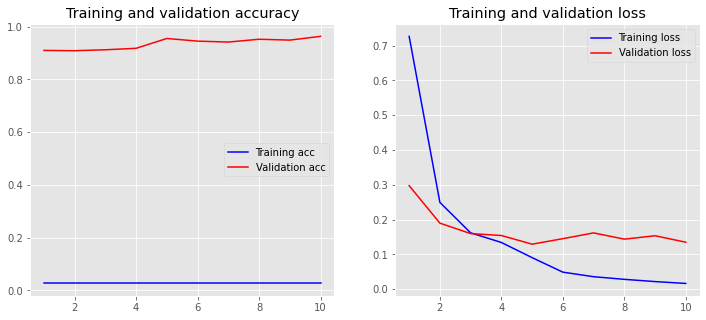

27625/27625 [==============================] - 77s 3ms/step
F1-score: 61.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.624857135263004,0.7523877451182099,0.6827178778713995,218721.0
test,0.4705561018245384,0.5339697495660798,0.5002613392183053,104858.0
treatment,0.5824556746076648,0.6455503569361374,0.6123821202567845,414640.0
micro avg,0.5799044073803964,0.6613552346932279,0.6179574400759433,738219.0
macro avg,0.5592896372317357,0.6439692838734757,0.5984537791154965,738219.0
weighted avg,0.579124040598114,0.6613552346932279,0.6172954947203154,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 227)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 227, 100)          2839100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 227, 200)          160800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 227, 7)            1407      
_________________________________________________________________
crf_2 (CRF)                  (None, 227, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 439s 22

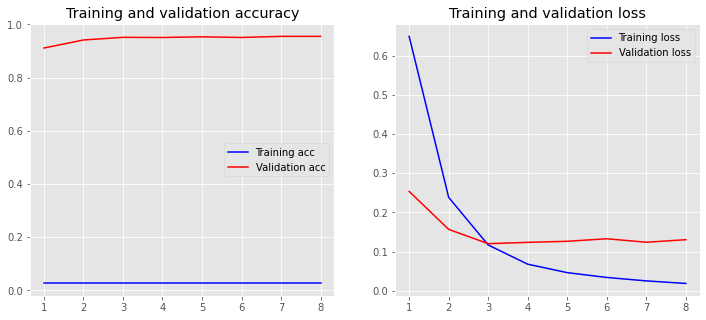

27625/27625 [==============================] - 77s 3ms/step
F1-score: 54.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.5245358000244137,0.707266334736948,0.6023475723127423,218721.0
test,0.4733988340331852,0.22148047836121232,0.30177499415265474,104858.0
treatment,0.5207252173338182,0.6078911827127147,0.5609421734795613,414640.0
micro avg,0.51927847327728,0.5824477560182005,0.5490521573627557,738219.0
macro avg,0.5062199504638057,0.5122126652702916,0.4883549133149861,738219.0
weighted avg,0.5151318968645969,0.5824477560182005,0.5363972595019089,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 229)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 229, 100)          2839100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 229, 200)          160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 229, 7)            1407      
_________________________________________________________________
crf_3 (CRF)                  (None, 229, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 452s 23

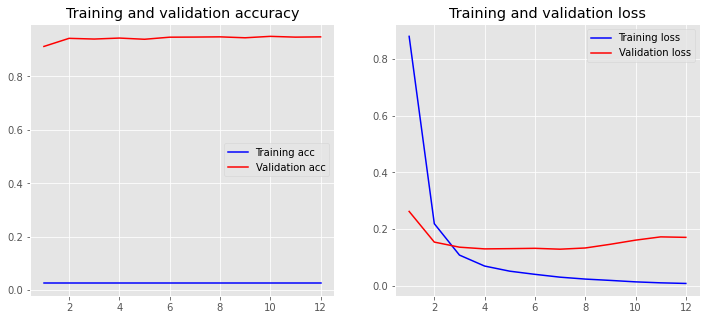

27625/27625 [==============================] - 81s 3ms/step
F1-score: 62.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.45560935032172656,0.7662730144796339,0.5714480548262811,218721.0
test,0.8108707217591772,0.6977054683476702,0.7500435714212486,104858.0
treatment,0.6574248968499513,0.6236831950607756,0.6401097031060682,414640.0
micro avg,0.5864920922388137,0.6764442529926756,0.6282647684003067,738219.0
macro avg,0.641301656310285,0.6958872259626933,0.6538671097845327,738219.0
weighted avg,0.6194263139851535,0.6764442529926756,0.6353817039491647,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 226)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 226, 100)          2839100   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 226, 200)          160800    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 226, 7)            1407      
_________________________________________________________________
crf_4 (CRF)                  (None, 226, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 452s 23

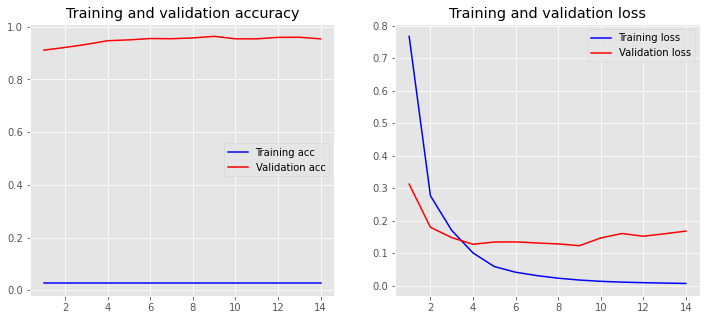

27625/27625 [==============================] - 86s 3ms/step
F1-score: 64.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.6144416531096331,0.7615226704340232,0.6801211928182638,218721.0
test,0.5758159062103929,0.6932327528657803,0.6290924196661156,104858.0
treatment,0.6394644432443264,0.6311040902951959,0.6352567611690836,414640.0
micro avg,0.6210919289405556,0.6785696385489942,0.6485598039818611,738219.0
macro avg,0.6099073341881175,0.6952865045316665,0.648156791217821,738219.0
weighted avg,0.6230098843974876,0.6785696385489942,0.6476736900660939,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 225)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 225, 100)          2839100   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 225, 200)          160800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 225, 7)            1407      
_________________________________________________________________
crf_5 (CRF)                  (None, 225, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 454s 23

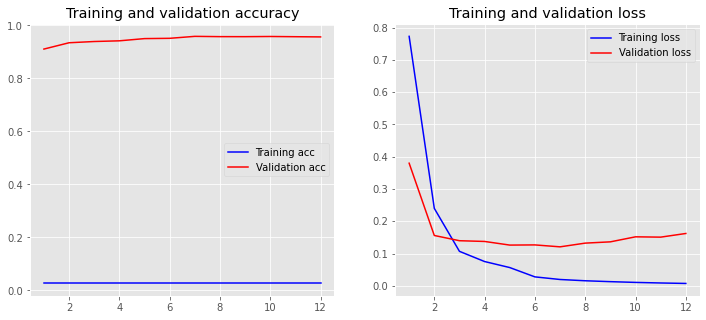

27625/27625 [==============================] - 84s 3ms/step
F1-score: 66.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.5932087240484731,0.7757188381545439,0.672297344150891,218721.0
test,0.7407950568037387,0.7225962730549886,0.7315825045862703,104858.0
treatment,0.653957335155722,0.6323485433146826,0.6429714350173313,414640.0
micro avg,0.6431962596691733,0.6876455360807565,0.6646786089793866,738219.0
macro avg,0.6626537053359779,0.7102212181747384,0.6822837612514975,738219.0
weighted avg,0.6482932068233154,0.6876455360807565,0.6642466551138896,738219.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 225)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 225, 100)          2839100   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 225, 200)          160800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 225, 7)            1407      
_________________________________________________________________
crf_6 (CRF)                  (None, 225, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 19578 samples, validate on 3263 samples
Epoch 1/100
19578/19578 [==============================] - 464s 24

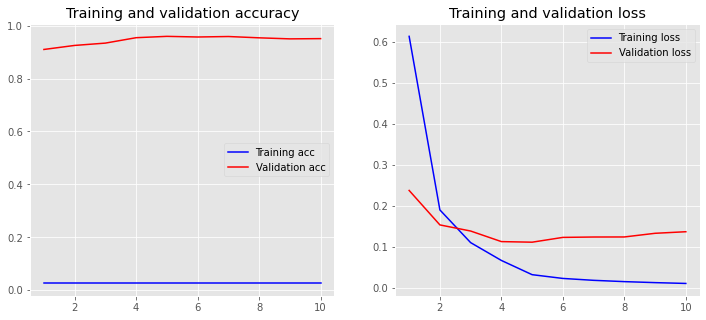

27625/27625 [==============================] - 81s 3ms/step
F1-score: 60.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.5494855213925492,0.7412594126764234,0.6311259554242405,218721.0
test,0.49053756642789403,0.7843464494840642,0.6035865125990291,104858.0
treatment,0.602113123733462,0.5596541578236542,0.5801077694768143,414640.0
micro avg,0.5617471584209781,0.6453762365910387,0.6006648011553646,738219.0
macro avg,0.5473787371846351,0.6950866733280473,0.6049400791666946,738219.0
weighted avg,0.5706721128687268,0.6453762365910387,0.5985585038725915,738219.0



In [ ]:
number_of_training_models = 6
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 226)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 226, 100)          2839100   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 226, 200)          160800    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 226, 7)            1407      
_________________________________________________________________
crf_7 (CRF)                  (None, 226, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 900s 23

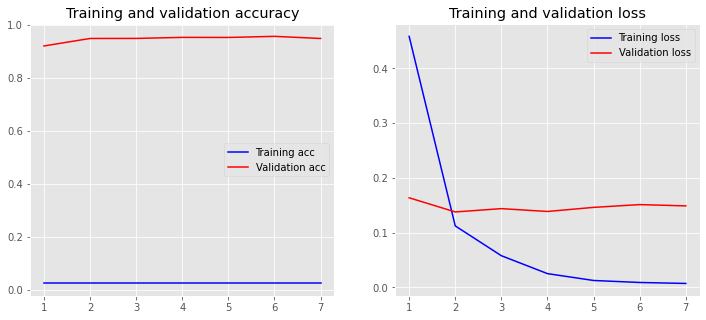

27625/27625 [==============================] - 84s 3ms/step
F1-score: 54.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.4164258464473057,0.798501287027766,0.5473852137760707,218721.0
test,0.39463869463869466,0.01614564458601156,0.03102209843515227,104858.0
treatment,0.5783017472123959,0.6221541578236542,0.5994269926875344,414640.0
micro avg,0.499340056934461,0.5883240610171236,0.5401920781894923,738219.0
macro avg,0.46312209609946536,0.4789336964791439,0.39261143496625245,738219.0
weighted avg,0.504252990328579,0.5883240610171236,0.5032706619417658,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 234)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 234, 100)          2839100   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 234, 200)          160800    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 234, 7)            1407      
_________________________________________________________________
crf_8 (CRF)                  (None, 234, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 927s 24

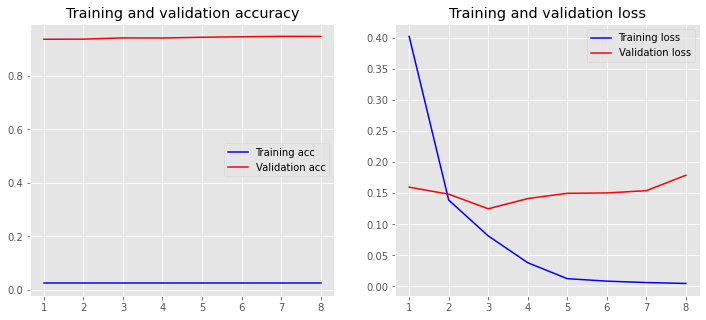

27625/27625 [==============================] - 85s 3ms/step
F1-score: 53.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.7119171728606791,0.7705478669172142,0.7400731136994874,218721.0
test,0.6685609135682199,0.2356138778157127,0.34843313682904126,104858.0
treatment,0.40046016958697367,0.5402300791047656,0.45996145786597326,414640.0
micro avg,0.5008624963537471,0.5652008414847085,0.5310902164242082,738219.0
macro avg,0.5936460853386242,0.5154639412792309,0.5161559027981673,738219.0
weighted avg,0.5308208010871297,0.5652008414847085,0.5271118086267521,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 231)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 231, 100)          2839100   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 231, 200)          160800    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 231, 7)            1407      
_________________________________________________________________
crf_9 (CRF)                  (None, 231, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 922s 24

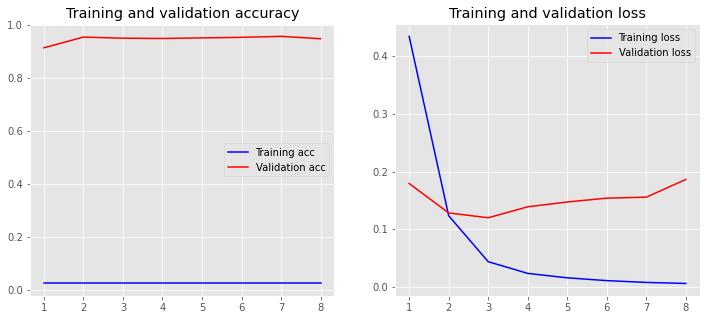

27625/27625 [==============================] - 88s 3ms/step
F1-score: 59.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.4855666757010878,0.6634708144165398,0.560746399576489,218721.0
test,0.7942125740560615,0.6852505292872265,0.735719039574054,104858.0
treatment,0.5486885606297615,0.6260056916843527,0.5848026603342541,414640.0
micro avg,0.5525714954945344,0.6455211800292325,0.5954407553092059,738219.0
macro avg,0.6094892701289703,0.658242345129373,0.6270893664949324,738219.0
weighted avg,0.5648613700621529,0.6455211800292325,0.599111666584605,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 231)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 231, 100)          2839100   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 231, 200)          160800    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 231, 7)            1407      
_________________________________________________________________
crf_10 (CRF)                 (None, 231, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 927s 2

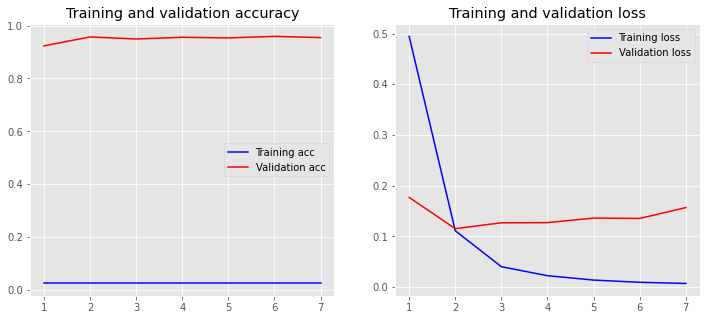

27625/27625 [==============================] - 85s 3ms/step
F1-score: 64.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.574011810632311,0.765724370316522,0.65615132068671,218721.0
test,0.6961548590992889,0.5041675408647885,0.5848073540636511,104858.0
treatment,0.6617628930538503,0.64734468454563,0.6544743893905,414640.0
micro avg,0.6320318834320208,0.6620813064957689,0.6467077198293656,738219.0
macro avg,0.6439765209284833,0.6390788652423135,0.6318110213802871,738219.0
weighted avg,0.6406489258940659,0.6620813064957689,0.6450755986518921,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 230)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 230, 100)          2839100   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 230, 200)          160800    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 230, 7)            1407      
_________________________________________________________________
crf_11 (CRF)                 (None, 230, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 891s 2

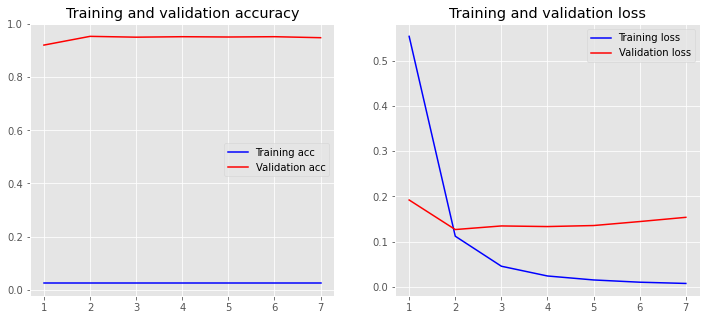

27625/27625 [==============================] - 82s 3ms/step
F1-score: 50.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.49557180842066806,0.3348878251288171,0.399684604555227,218721.0
test,0.7386064878902017,0.656411527971161,0.6950875297277919,104858.0
treatment,0.41785645595589177,0.6287598880956975,0.5020586196271761,414640.0
micro avg,0.46569593207170207,0.5456185766012525,0.5024991719329237,738219.0
macro avg,0.5506782507555871,0.5400197470652252,0.5322769179700649,738219.0
weighted avg,0.48644204702712696,0.5456185766012525,0.4991452274018048,738219.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 225)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 225, 100)          2839100   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 225, 200)          160800    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 225, 7)            1407      
_________________________________________________________________
crf_12 (CRF)                 (None, 225, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 886s 2

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 233)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 233, 100)          2839100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 233, 200)          160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 233, 7)            1407      
_________________________________________________________________
crf_1 (CRF)                  (None, 233, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________

Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 670s 1

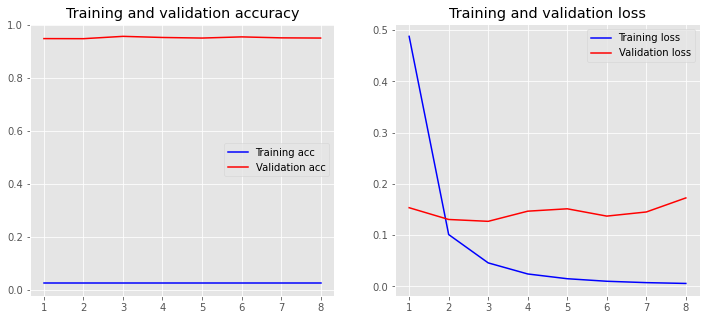

27625/27625 [==============================] - 69s 2ms/step
F1-score: 62.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.5604520840779279,0.7599636066038469,0.6451349982437518,218721.0
test,0.5845876672938336,0.6281733391825135,0.6055972859415081,104858.0
treatment,0.6114432292361336,0.6191467296932278,0.6152708674853565,414640.0
micro avg,0.5895537689266477,0.662150391685936,0.6237468425824374,738219.0
macro avg,0.5854943268692984,0.669094558493196,0.6220010505568722,738219.0
weighted avg,0.5925208569126177,0.662150391685936,0.6227450182862463,738219.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 226)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 226, 100)          2839100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 226, 200)          160800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 226, 7)            1407      
_________________________________________________________________
crf_2 (CRF)                  (None, 226, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 688s 18

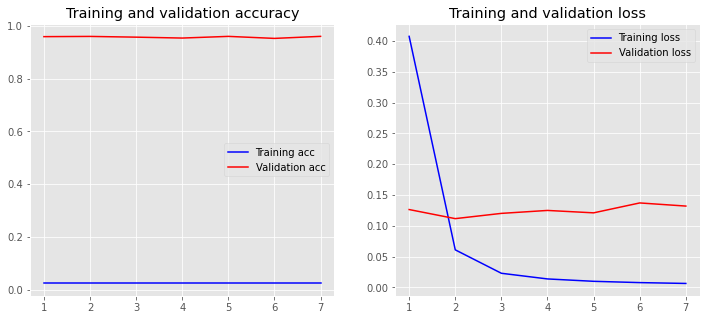

27625/27625 [==============================] - 68s 2ms/step
F1-score: 64.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.5342046207907571,0.7847120303948867,0.6356683604687338,218721.0
test,0.6482134200948132,0.7524080184630644,0.6964351130550688,104858.0
treatment,0.6393901454664498,0.6170629944047848,0.628028193387097,414640.0
micro avg,0.6005828068423469,0.685959044673735,0.6404380983697784,738219.0
macro avg,0.6072693954506733,0.718061014420912,0.6533772223036332,738219.0
weighted avg,0.6094788424363039,0.685959044673735,0.6400084834728397,738219.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 227)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 227, 100)          2839100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 227, 200)          160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 227, 7)            1407      
_________________________________________________________________
crf_3 (CRF)                  (None, 227, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 728s 19

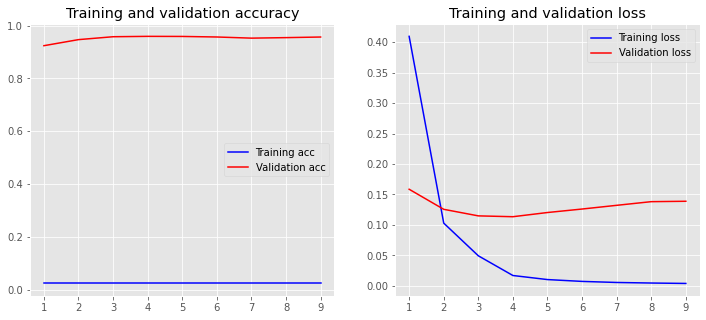

27625/27625 [==============================] - 68s 2ms/step
F1-score: 61.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.5683800898574309,0.7345613818517654,0.6408730910606693,218721.0
test,0.6509108404950725,0.7483072345457666,0.696219266567882,104858.0
treatment,0.5660516325520482,0.5764446266640941,0.5712008584132022,414640.0
micro avg,0.5792414270156069,0.6477034592715711,0.6115623940806681,738219.0
macro avg,0.5951141876348506,0.6864377476872088,0.6360977386805845,738219.0
weighted avg,0.578795072285759,0.6477034592715711,0.6096013339349242,738219.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 233)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 233, 100)          2839100   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 233, 200)          160800    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 233, 7)            1407      
_________________________________________________________________
crf_4 (CRF)                  (None, 233, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 753s 19

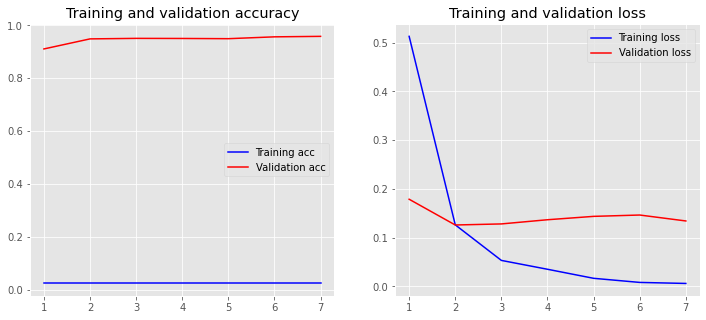

27625/27625 [==============================] - 63s 2ms/step
F1-score: 55.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.5489131000683759,0.7230627145998784,0.6240662623265211,218721.0
test,0.4571820315586438,0.18761563256976102,0.2660508895184902,104858.0
treatment,0.5120689096462163,0.6097650974339186,0.5566630118407553,414640.0
micro avg,0.5220744048917919,0.5833702464986678,0.5510229279942371,738219.0
macro avg,0.506054680424412,0.5068144815345194,0.4822600545619222,738219.0
weighted avg,0.5151889457206312,0.5833702464986678,0.5353542950873652,738219.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 230)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 230, 100)          2839100   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 230, 200)          160800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 230, 7)            1407      
_________________________________________________________________
crf_5 (CRF)                  (None, 230, 7)            119       
Total params: 3,001,426
Trainable params: 3,001,426
Non-trainable params: 0
_________________________________________________________________
Train on 39156 samples, validate on 3263 samples
Epoch 1/100
39156/39156 [==============================] - 686s 18

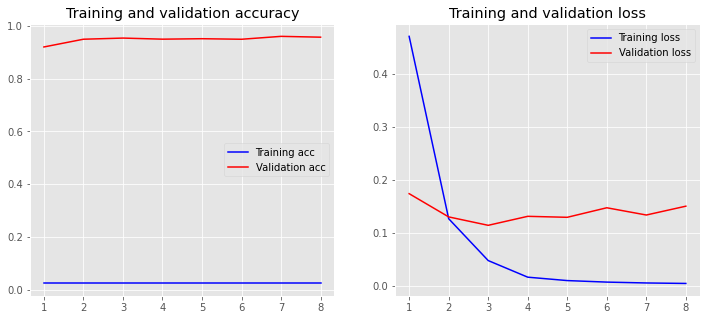

27625/27625 [==============================] - 68s 2ms/step
F1-score: 60.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.5111609593410539,0.7876381325981502,0.6199725053261933,218721.0
test,0.7800636310625978,0.7271929657250759,0.7527010152559857,104858.0
treatment,0.5526208904547197,0.5840849893883852,0.567917475682622,414640.0
micro avg,0.5620820552059398,0.6647214444494114,0.6091081346614193,738219.0
macro avg,0.6146151602861237,0.6996386959038704,0.6468636654216003,738219.0
weighted avg,0.5726434492097081,0.6647214444494114,0.6095874415481107,738219.0



In [13]:
number_of_training_models = 5
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)